In [1]:
from collections import defaultdict
from copy import deepcopy

import networkx as nx 
import nxviz as nv
import pandas as pd
from gensim.corpora import Dictionary
from nltk.corpus import wordnet as wn

import matplotlib.pyplot as plt

% matplotlib inline

In [2]:
sg_43_232 = nx.read_gpickle("../data/subgraphs/43/232.gpickle")  # 1.0

In [3]:
sg_43_232.node[14145]

{'vector_ind': 232,
 'term_id': 420,
 'freq_per_doc': 1.0,
 'type': 'SPA',
 'tf-idf': 0.08968273794509804,
 'doc_name': 'Le Roy Goldman'}

In [4]:
term_dictionary = Dictionary.load('../data/spa.dict')

In [5]:
max(term_dictionary)

6018

In [6]:
syns = [node for node, data in sg_43_232.nodes(data=True) if data['type'] == 'SYN']

In [7]:
syn_neighbors = list()
for syn in syns:
    syn_neighbors.extend(sg_43_232.neighbors(syn))
    
syn_neighbors = set(syn_neighbors)

In [8]:
term_dictionary[2369]

'vestige'

In [9]:
sg_sub = sg_43_232.subgraph([node for node, data in sg_43_232.nodes(data=True) if data['type'] != 'SYN'])
max_node = max([node for node in sg_sub.nodes()])

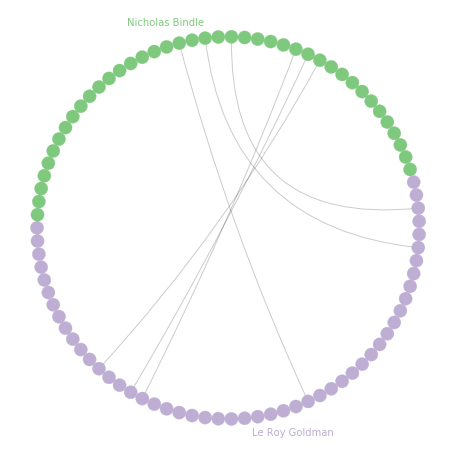

In [10]:
ap = nv.CircosPlot(
    sg_sub, 
    node_color='vector_ind', 
    node_order='vector_ind', 
    node_grouping='doc_name', 
    group_label_position='middle',
    group_label_color=True,
    figsize=(8, 8)
)

ap.draw()
plt.show();

In [11]:
# I need to create a brand new graph, since I will ultimately be altering it. 
# Apparently, you cannot alter a subgraph.. SMH
new_graph = nx.Graph()
nodes_list = list()
edges_list = list()

for node, data in sg_sub.nodes(data=True):
    data['term'] = term_dictionary[data['term_id']]
    nodes_list.append((node, data))
    for neighbor in nx.neighbors(sg_sub, node):
        edges_list.append((node, neighbor))
        
new_graph.add_nodes_from(nodes_list)
new_graph.add_edges_from(edges_list)

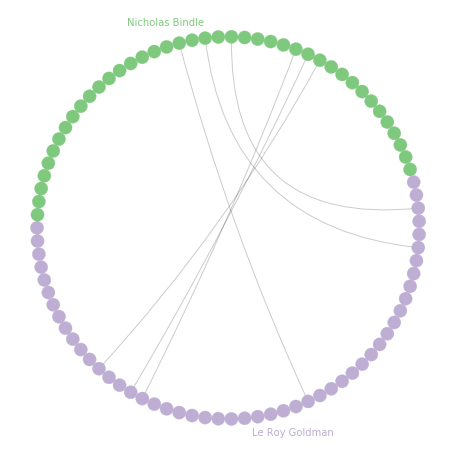

In [12]:
# They are the same
ap = nv.CircosPlot(
    new_graph, 
    node_color='vector_ind', 
    node_order='vector_ind', 
    node_grouping='doc_name', 
    group_label_position='middle',
    group_label_color=True,
    figsize=(8, 8)
)

ap.draw()
plt.show();

In [13]:
syns_per_term = defaultdict(set)
syn_to_node_map = dict()
syn_dictionary = Dictionary()

node_count = max_node + 1
for term_id in syn_neighbors:
    # If a node from P1 is already connected to a node in P2, we don't want to find the syns
    if len(list(new_graph.neighbors(term_id))) == 0:
        term = term_dictionary[new_graph.node[term_id]['term_id']]

        term_syns = wn.synsets(term)

        for syn_obj in term_syns:
            # extracts the text value from the syn object
            syn = syn_obj.name().split('.')[0]

            if syn not in syn_dictionary.token2id:
                syn_dictionary.add_documents([[syn]])

                # add syn node to graph
                new_graph.add_node(
                    node_count,
                    type='SYN',
                    term_id=syn_dictionary.token2id[syn],
                    term=syn,
                    freq_per_doc=-1,
                    vector_ind=-1,
                    doc_name='Synonyms'
                )
                syn_to_node_map[syn_dictionary.token2id[syn]] = node_count

                node_count += 1

            if syn not in syns_per_term[term_id]:
                syns_per_term[term_id].add(syn)

                new_graph.add_edge(
                    term_id,
                    syn_to_node_map[syn_dictionary.token2id[syn]],
                    attr_dict={'weight': 0.5}
                )

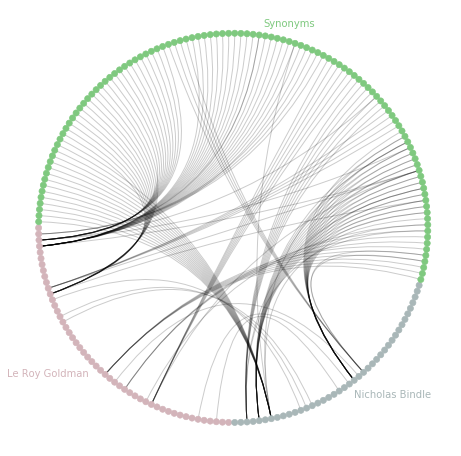

In [14]:
# They are the same
ap = nv.CircosPlot(
    new_graph, 
    node_color='vector_ind', 
    node_order='vector_ind', 
    node_grouping='doc_name', 
    group_label_position='middle',
    group_label_color=True,
    figsize=(8, 8)
)

ap.draw()
plt.show();

In [15]:
new_graph_with_sim_syn_list = list()

for node, data in new_graph.nodes(data=True):
    if data['type'] != 'SYN':
        new_graph_with_sim_syn_list.append(node)
    else:
        neighbors = list(nx.neighbors(new_graph, node))
        unique_vectors = set([new_graph.node[n]['vector_ind'] for n in neighbors])
        
        if len(unique_vectors) > 1:
            new_graph_with_sim_syn_list.append(node)
            
new_graph_with_sim_syn = new_graph.subgraph(new_graph_with_sim_syn_list)

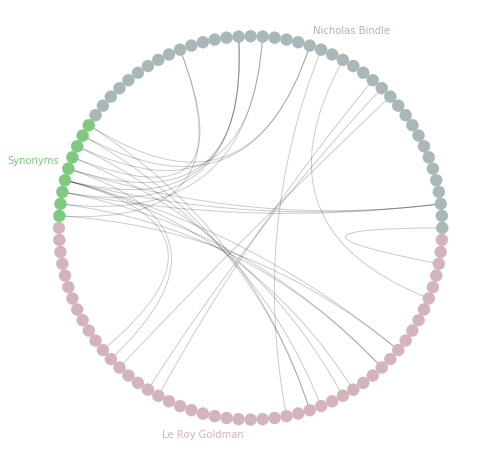

In [16]:
# They are the same
ap = nv.CircosPlot(
    new_graph_with_sim_syn, 
    node_color='vector_ind', 
    node_order='vector_ind', 
    node_grouping='doc_name', 
    group_label_position='middle',
    group_label_color=True,
    figsize=(8, 8)
)

ap.draw()
plt.show();

In [17]:
node_labels = {node: f"{node}-{data['term']}" for node, data in new_graph_with_sim_syn.nodes(data=True)}
new_graph_with_sim_syn = nx.relabel_nodes(new_graph_with_sim_syn, node_labels)

In [18]:
# now to determine the scores
same_words_subgraph_list = set()
syn_subgraph_list = set()
for node, data in new_graph_with_sim_syn.nodes(data=True):
    if data['type'] == 'SPA':
        for node in [n for n in new_graph_with_sim_syn.neighbors(node) if new_graph_with_sim_syn.node[n]['type'] == 'SPA']:
            same_words_subgraph_list.add(node)
            
    else:
        syn_subgraph_list.add(node)
        for neighbor in new_graph_with_sim_syn.neighbors(node):
            syn_subgraph_list.add(neighbor)

In [19]:
same_words_subgraph = new_graph_with_sim_syn.subgraph(list(same_words_subgraph_list))
syn_words_subgraph = new_graph_with_sim_syn.subgraph(list(syn_subgraph_list))

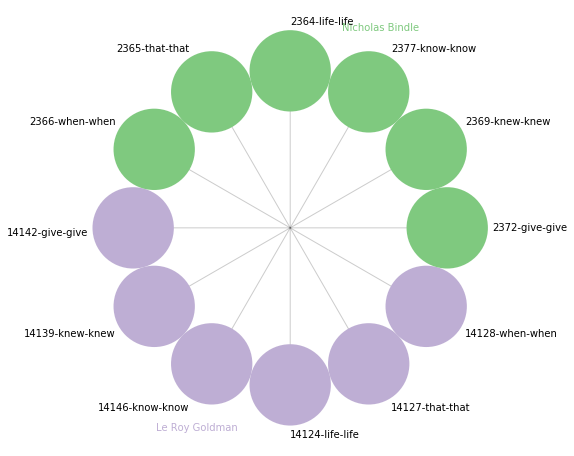

In [20]:
node_labels = {node: f"{node}-{data['term']}" for node, data in same_words_subgraph.nodes(data=True)}
same_words_subgraph = nx.relabel_nodes(same_words_subgraph, node_labels)

# They are the same
ap = nv.CircosPlot(
    same_words_subgraph, 
    node_color='vector_ind', 
    node_order='term', 
    node_grouping='doc_name', 
    group_label_position='middle',
    group_label_color=True,
    node_labels=True,
    figsize=(8, 8)
)

ap.draw()
plt.show();

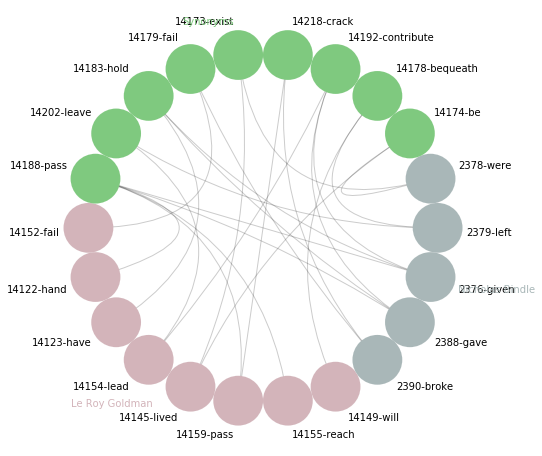

In [21]:
# They are the same
ap = nv.CircosPlot(
    syn_words_subgraph, 
    node_color='vector_ind', 
    node_order='term', 
    node_grouping='doc_name', 
    group_label_position='middle',
    group_label_color=True,
    node_labels=True,
    figsize=(8, 8)
)

ap.draw()
plt.show();

In [22]:
# Now for scoring!!
BASE_V_IND = 43
overall_score = 0

In [23]:
for node, data in same_words_subgraph.nodes(data=True):
    if data['vector_ind'] == BASE_V_IND:
        overall_score += data['tf-idf']
        for neighbor in same_words_subgraph.neighbors(node):
            overall_score += same_words_subgraph.node[neighbor]['tf-idf']

In [24]:
overall_score

1.1316510318117912

In [25]:
for p1_node, p1_data in syn_words_subgraph.nodes(data=True):
    if p1_data['vector_ind'] == BASE_V_IND:
        # for all syns..
        for syn_node in syn_words_subgraph.neighbors(p1_node):
            syn_p2_neighbors = [n for n in syn_words_subgraph.neighbors(syn_node) if syn_words_subgraph.node[n]['vector_ind'] != BASE_V_IND]
            
            p2_syn_scores = 0
            # for all P2 nodes associated with the syn..
            for p2_node in syn_p2_neighbors:
                p2_syn_scores += (p1_data['tf-idf'] + syn_words_subgraph.node[p2_node]['tf-idf']) / len(syn_p2_neighbors)
                
            overall_score += p2_syn_scores * 0.5

In [26]:
overall_score

2.646772055113475

In [27]:
import os
from collections import defaultdict

term_dictionary = Dictionary.load('../data/spa.dict')
syn_dictionary = Dictionary()
path_map = list()

for directory in os.listdir('../data/subgraphs/'):
    for file in os.listdir('../data/subgraphs/' + directory + '/'):
        poem_ind = file.split('.')[0]
        path_map.append((directory, poem_ind))

In [28]:
path_map[0]

('0', '1')

In [29]:
for ind, (p1, p2) in enumerate(path_map):
    print(f"{p1}-{p2}: {(ind / len(path_map)) * 100}%")
    
    # Read in original subgraph
    original_subgraph = nx.read_gpickle(f"../data/subgraphs/{p1}/{p2}.gpickle")

    # Bring out the synonyms so that we can determine which nodes are associated
    syn_nodes = list()
    spa_nodes = list()
    syn_neighbors = set()
    for node, data in original_subgraph.nodes(data=True):
        # keep track of all syns
        if data['type'] == 'SYN':
            syn_nodes.append(node)

            # Keep track of all nodes that are associated with a synonym
            for syn_neighbor in original_subgraph.neighbors(node):
                syn_neighbors.add(syn_neighbor)

        # keep track of all spa nodes
        else:
            spa_nodes.append(node)


    # Create a subgraph of the original, excluding the synonyms. 
    # Ultimate goal is to re-map the synonyms with something we can read, 
    # and right now they cant be read.
    original_subgraph_without_syns = original_subgraph.subgraph(spa_nodes)
    max_node = max(spa_nodes)


    # I need to create a brand new graph, since I will ultimately be altering it. 
    # Apparently, you cannot alter a subgraph.. SMH
    new_graph = nx.Graph()

    nodes_list = list()
    edges_list = list()

    # copy all nodes and edges of original, and create the new one
    for node, data in original_subgraph_without_syns.nodes(data=True):
        data['term'] = term_dictionary[data['term_id']]
        nodes_list.append((node, data))
        for neighbor in original_subgraph_without_syns.neighbors(node):
            edges_list.append((node, neighbor))

    new_graph.add_nodes_from(nodes_list)
    new_graph.add_edges_from(edges_list)


    # Now I need to include synonyms between the spa nodes
    syns_per_term = defaultdict(set)
    syn_to_node_map = dict()

    nodes_to_keep = list()

    # This is to ensure all values are unique within the subgraph
    node_count = max_node + 1
    for term_id in syn_neighbors:
        # If a node from P1 is already connected to a node in P2, we don't want to find the syns
        if list(new_graph.neighbors(term_id)):
            nodes_to_keep.append(term_id)
            continue

        term = term_dictionary[new_graph.node[term_id]['term_id']]

        # make a call to the wordnet synsets api for the syns associated with the term
        term_syns = wn.synsets(term)

        for syn_obj in term_syns:
            # extracts the text value from the syn object
            syn = syn_obj.name().split('.')[0]

            if syn not in syn_dictionary.token2id:
                syn_dictionary.add_documents([[syn]])

            syn_dict_id = syn_dictionary.token2id[syn]

            # the syn doesn't yet exist with this subgraph
            if syn_dict_id not in syn_to_node_map:
                # add syn node to graph
                new_graph.add_node(
                    node_count,
                    type='SYN',
                    term_id=syn_dict_id,
                    freq_per_doc=-1,
                    vector_ind=-1,
                    doc_name='Synonyms'
                )
                syn_to_node_map[syn_dict_id] = {
                    'node_id': node_count,
                    'count': 0,
                    'poem_types': set()
                }

                node_count += 1

            # sometimes, the same syn appears multiple times for a given word, to this fixes that
            if syn not in syns_per_term[term_id]:
                syns_per_term[term_id].add(syn)

                syn_to_node_map[syn_dict_id]['count'] += 1
                syn_to_node_map[syn_dict_id]['poem_types'].add(new_graph.node[term_id]['vector_ind'])

                new_graph.add_edge(
                    term_id,
                    syn_to_node_map[syn_dict_id]['node_id']
                )


    shared_syns = list()
    for syn_dict_id, desc in syn_to_node_map.items():
        if desc['count'] > 1 and len(desc['poem_types']) > 1:
            shared_syns.append(desc['node_id'])
            nodes_to_keep.extend(new_graph.neighbors(desc['node_id']))

    new_graph_with_sim_syn = new_graph.subgraph(shared_syns + nodes_to_keep)
    
    nx.write_gpickle(new_graph_with_sim_syn, f"../data/subgraphs_2/{p1}/{p2}.gpickle")
    
syn_dictionary.save('../data/spa.dict')

0-1: 0.0%
0-10: 0.0033182904167772765%
0-100: 0.006636580833554553%
0-101: 0.009954871250331829%
0-102: 0.013273161667109106%
0-103: 0.01659145208388638%
0-104: 0.019909742500663657%
0-105: 0.023228032917440935%
0-106: 0.026546323334218212%
0-107: 0.029864613750995486%
0-108: 0.03318290416777276%
0-109: 0.03650119458455004%
0-11: 0.039819485001327315%
0-110: 0.043137775418104596%
0-111: 0.04645606583488187%
0-112: 0.04977435625165915%
0-113: 0.053092646668436425%
0-114: 0.0564109370852137%
0-115: 0.05972922750199097%
0-116: 0.06304751791876825%
0-117: 0.06636580833554552%
0-118: 0.0696840987523228%
0-119: 0.07300238916910008%
0-12: 0.07632067958587735%
0-120: 0.07963897000265463%
0-121: 0.08295726041943191%
0-122: 0.08627555083620919%
0-123: 0.08959384125298646%
0-124: 0.09291213166976374%
0-125: 0.09623042208654102%
0-126: 0.0995487125033183%
0-127: 0.10286700292009557%
0-128: 0.10618529333687285%
0-129: 0.10950358375365012%
0-13: 0.1128218741704274%
0-130: 0.11614016458720466%
0-131:

1-154: 1.0153968675338465%
1-155: 1.0187151579506237%
1-156: 1.0220334483674012%
1-157: 1.0253517387841784%
1-158: 1.0286700292009556%
1-159: 1.031988319617733%
1-16: 1.0353066100345103%
1-160: 1.0386249004512875%
1-161: 1.0419431908680648%
1-162: 1.0452614812848422%
1-163: 1.0485797717016192%
1-164: 1.0518980621183966%
1-165: 1.0552163525351739%
1-166: 1.058534642951951%
1-167: 1.0618529333687283%
1-168: 1.0651712237855058%
1-169: 1.068489514202283%
1-17: 1.0718078046190602%
1-170: 1.0751260950358377%
1-171: 1.078444385452615%
1-172: 1.0817626758693921%
1-173: 1.0850809662861693%
1-174: 1.0883992567029468%
1-175: 1.0917175471197238%
1-176: 1.0950358375365012%
1-177: 1.0983541279532785%
1-178: 1.1016724183700557%
1-179: 1.104990708786833%
1-18: 1.1083089992036104%
1-180: 1.1116272896203876%
1-181: 1.1149455800371648%
1-182: 1.118263870453942%
1-183: 1.1215821608707195%
1-184: 1.1249004512874967%
1-185: 1.128218741704274%
1-186: 1.1315370321210514%
1-187: 1.1348553225378284%
1-188: 1.13

10-212: 2.0341120254844705%
10-213: 2.0374303159012475%
10-214: 2.040748606318025%
10-215: 2.0440668967348024%
10-216: 2.0473851871515794%
10-217: 2.050703477568357%
10-218: 2.0540217679851343%
10-219: 2.0573400584019113%
10-22: 2.0606583488186883%
10-220: 2.063976639235466%
10-221: 2.067294929652243%
10-222: 2.0706132200690206%
10-223: 2.0739315104857976%
10-224: 2.077249800902575%
10-225: 2.0805680913193525%
10-226: 2.0838863817361295%
10-227: 2.087204672152907%
10-228: 2.0905229625696844%
10-229: 2.0938412529864614%
10-23: 2.0971595434032384%
10-230: 2.100477833820016%
10-231: 2.1037961242367933%
10-232: 2.1071144146535703%
10-233: 2.1104327050703477%
10-234: 2.113750995487125%
10-235: 2.117069285903902%
10-236: 2.1203875763206796%
10-237: 2.1237058667374566%
10-238: 2.127024157154234%
10-239: 2.1303424475710115%
10-24: 2.1336607379877885%
10-240: 2.136979028404566%
10-241: 2.1402973188213434%
10-242: 2.1436156092381204%
10-243: 2.1469338996548974%
10-244: 2.1502521900716753%
10-245

101-139: 3.00968940801699%
101-140: 3.013007698433767%
101-141: 3.0163259888505443%
101-142: 3.0196442792673217%
101-143: 3.0229625696840987%
101-144: 3.0262808601008757%
101-145: 3.0295991505176536%
101-146: 3.0329174409344306%
101-147: 3.0362357313512076%
101-148: 3.039554021767985%
101-149: 3.0428723121847625%
101-150: 3.04619060260154%
101-151: 3.049508893018317%
101-152: 3.052827183435094%
101-153: 3.056145473851872%
101-154: 3.059463764268649%
101-155: 3.062782054685426%
101-156: 3.0661003451022033%
101-157: 3.0694186355189808%
101-158: 3.0727369259357578%
101-159: 3.076055216352535%
101-160: 3.0793735067693127%
101-161: 3.0826917971860897%
101-162: 3.086010087602867%
101-163: 3.089328378019644%
101-164: 3.0926466684364216%
101-165: 3.095964958853199%
101-166: 3.099283249269976%
101-167: 3.1026015396867535%
101-168: 3.105919830103531%
101-169: 3.109238120520308%
101-170: 3.112556410937085%
101-171: 3.1158747013538624%
101-172: 3.11919299177064%
101-173: 3.122511282187417%
101-174

103-143: 3.9686753384656224%
103-144: 3.9719936288824%
103-145: 3.9753119192991773%
103-146: 3.9786302097159547%
103-147: 3.9819485001327317%
103-148: 3.985266790549509%
103-149: 3.9885850809662866%
103-150: 3.991903371383063%
103-151: 3.9952216617998406%
103-152: 3.9985399522166185%
103-153: 4.0018582426333955%
103-154: 4.0051765330501725%
103-155: 4.00849482346695%
103-156: 4.0118131138837265%
103-157: 4.015131404300504%
103-158: 4.018449694717282%
103-159: 4.021767985134058%
103-160: 4.025086275550836%
103-161: 4.028404565967614%
103-162: 4.03172285638439%
103-163: 4.035041146801168%
103-164: 4.038359437217945%
103-165: 4.041677727634722%
103-166: 4.0449960180515%
103-167: 4.048314308468277%
103-168: 4.051632598885054%
103-169: 4.054950889301832%
103-170: 4.058269179718609%
103-171: 4.061587470135386%
103-172: 4.064905760552164%
103-173: 4.068224050968941%
103-174: 4.071542341385718%
103-175: 4.074860631802495%
103-176: 4.078178922219273%
103-177: 4.08149721263605%
103-178: 4.084815

105-156: 4.944252720998142%
105-157: 4.947571011414919%
105-158: 4.950889301831697%
105-159: 4.954207592248474%
105-160: 4.957525882665251%
105-161: 4.9608441730820285%
105-162: 4.9641624634988055%
105-163: 4.9674807539155825%
105-164: 4.97079904433236%
105-165: 4.974117334749137%
105-166: 4.977435625165914%
105-167: 4.980753915582692%
105-168: 4.984072205999469%
105-169: 4.987390496416246%
105-170: 4.990708786833023%
105-171: 4.994027077249801%
105-172: 4.997345367666578%
105-173: 5.000663658083355%
105-174: 5.003981948500133%
105-175: 5.00730023891691%
105-176: 5.010618529333687%
105-177: 5.013936819750465%
105-178: 5.017255110167242%
105-179: 5.020573400584019%
105-180: 5.023891691000797%
105-181: 5.027209981417573%
105-182: 5.030528271834351%
105-183: 5.033846562251129%
105-184: 5.037164852667905%
105-185: 5.040483143084683%
105-186: 5.043801433501461%
105-187: 5.047119723918237%
105-188: 5.050438014335015%
105-189: 5.053756304751792%
105-190: 5.057074595168569%
105-191: 5.06039288

107-172: 5.916511813113884%
107-173: 5.919830103530661%
107-174: 5.9231483939474385%
107-175: 5.9264666843642155%
107-176: 5.929784974780993%
107-177: 5.93310326519777%
107-178: 5.936421555614547%
107-179: 5.939739846031325%
107-180: 5.943058136448101%
107-181: 5.946376426864879%
107-182: 5.949694717281657%
107-183: 5.953013007698433%
107-184: 5.956331298115211%
107-185: 5.959649588531988%
107-186: 5.962967878948765%
107-187: 5.966286169365543%
107-188: 5.96960445978232%
107-189: 5.972922750199097%
107-190: 5.976241040615875%
107-191: 5.979559331032652%
107-192: 5.982877621449429%
107-193: 5.986195911866207%
107-194: 5.989514202282984%
107-195: 5.992832492699761%
107-196: 5.996150783116539%
107-197: 5.999469073533316%
107-198: 6.002787363950093%
107-199: 6.00610565436687%
107-200: 6.009423944783648%
107-201: 6.012742235200425%
107-202: 6.016060525617202%
107-203: 6.01937881603398%
107-204: 6.022697106450757%
107-205: 6.026015396867534%
107-206: 6.0293336872843115%
107-207: 6.0326519777

109-192: 6.8887709052296255%
109-193: 6.892089195646403%
109-194: 6.89540748606318%
109-195: 6.898725776479958%
109-196: 6.902044066896734%
109-197: 6.9053623573135114%
109-198: 6.908680647730289%
109-199: 6.911998938147066%
109-200: 6.915317228563844%
109-201: 6.918635518980622%
109-202: 6.921953809397398%
109-203: 6.925272099814175%
109-204: 6.928590390230953%
109-205: 6.93190868064773%
109-206: 6.935226971064508%
109-207: 6.938545261481285%
109-208: 6.941863551898061%
109-209: 6.945181842314839%
109-210: 6.948500132731617%
109-211: 6.951818423148394%
109-212: 6.955136713565172%
109-213: 6.958455003981949%
109-214: 6.961773294398725%
109-215: 6.965091584815503%
109-216: 6.96840987523228%
109-217: 6.971728165649058%
109-218: 6.975046456065835%
109-219: 6.978364746482613%
109-220: 6.9816830368993905%
109-221: 6.985001327316167%
109-222: 6.988319617732944%
109-223: 6.9916379081497215%
109-224: 6.9949561985664985%
109-225: 6.998274488983276%
109-226: 7.001592779400053%
109-227: 7.0049110

110-128: 7.900849482346695%
110-129: 7.904167772763472%
110-130: 7.90748606318025%
110-131: 7.910804353597027%
110-132: 7.914122644013805%
110-133: 7.917440934430581%
110-134: 7.920759224847358%
110-135: 7.924077515264136%
110-136: 7.927395805680913%
110-137: 7.930714096097691%
110-138: 7.934032386514469%
110-139: 7.937350676931245%
110-140: 7.940668967348022%
110-141: 7.9439872577648%
110-142: 7.947305548181577%
110-143: 7.9506238385983545%
110-144: 7.9539421290151315%
110-145: 7.957260419431909%
110-146: 7.9605787098486855%
110-147: 7.963897000265463%
110-148: 7.96721529068224%
110-149: 7.970533581099018%
110-150: 7.973851871515795%
110-151: 7.977170161932573%
110-152: 7.980488452349349%
110-153: 7.983806742766126%
110-154: 7.987125033182904%
110-155: 7.990443323599681%
110-156: 7.993761614016459%
110-157: 7.997079904433237%
110-158: 8.000398194850012%
110-159: 8.003716485266791%
110-160: 8.007034775683568%
110-161: 8.010353066100345%
110-162: 8.013671356517122%
110-163: 8.0169896469

112-156: 8.879745155295991%
112-157: 8.883063445712768%
112-158: 8.886381736129547%
112-159: 8.889700026546324%
112-160: 8.8930183169631%
112-161: 8.896336607379878%
112-162: 8.899654897796655%
112-163: 8.902973188213432%
112-164: 8.90629147863021%
112-165: 8.909609769046988%
112-166: 8.912928059463763%
112-167: 8.916246349880542%
112-168: 8.919564640297319%
112-169: 8.922882930714096%
112-170: 8.926201221130874%
112-171: 8.929519511547651%
112-172: 8.932837801964428%
112-173: 8.936156092381205%
112-174: 8.939474382797982%
112-175: 8.94279267321476%
112-176: 8.946110963631536%
112-177: 8.949429254048315%
112-178: 8.952747544465092%
112-179: 8.95606583488187%
112-180: 8.959384125298646%
112-181: 8.962702415715423%
112-182: 8.9660207061322%
112-183: 8.969338996548979%
112-184: 8.972657286965756%
112-185: 8.975975577382531%
112-186: 8.97929386779931%
112-187: 8.982612158216087%
112-188: 8.985930448632864%
112-189: 8.989248739049643%
112-190: 8.99256702946642%
112-191: 8.995885319883195%
1

114-188: 9.858640828245289%
114-189: 9.861959118662066%
114-190: 9.865277409078843%
114-191: 9.86859569949562%
114-192: 9.871913989912397%
114-193: 9.875232280329174%
114-194: 9.878550570745952%
114-195: 9.88186886116273%
114-196: 9.885187151579506%
114-197: 9.888505441996283%
114-198: 9.89182373241306%
114-199: 9.895142022829837%
114-200: 9.898460313246616%
114-201: 9.901778603663393%
114-202: 9.90509689408017%
114-203: 9.908415184496947%
114-204: 9.911733474913724%
114-205: 9.915051765330501%
114-206: 9.918370055747278%
114-207: 9.921688346164057%
114-208: 9.925006636580834%
114-209: 9.928324926997611%
114-210: 9.931643217414388%
114-211: 9.934961507831165%
114-212: 9.938279798247942%
114-213: 9.94159808866472%
114-214: 9.944916379081498%
114-215: 9.948234669498275%
114-216: 9.951552959915052%
114-217: 9.954871250331829%
114-218: 9.958189540748606%
114-219: 9.961507831165385%
114-220: 9.964826121582162%
114-221: 9.968144411998939%
114-222: 9.971462702415716%
114-223: 9.97478099283249

116-215: 10.807671887443588%
116-216: 10.810990177860367%
116-217: 10.814308468277144%
116-218: 10.81762675869392%
116-219: 10.8209450491107%
116-220: 10.824263339527475%
116-221: 10.827581629944252%
116-222: 10.83089992036103%
116-223: 10.834218210777808%
116-224: 10.837536501194585%
116-225: 10.840854791611362%
116-226: 10.844173082028139%
116-227: 10.847491372444916%
116-228: 10.850809662861693%
116-229: 10.854127953278471%
116-230: 10.857446243695248%
116-231: 10.860764534112025%
116-232: 10.864082824528802%
116-233: 10.86740111494558%
116-234: 10.870719405362356%
116-235: 10.874037695779135%
116-236: 10.877355986195912%
116-237: 10.88067427661269%
116-238: 10.883992567029468%
116-239: 10.887310857446243%
116-240: 10.89062914786302%
116-241: 10.893947438279799%
116-242: 10.897265728696576%
116-243: 10.900584019113353%
116-244: 10.90390230953013%
116-245: 10.907220599946907%
117-118: 10.910538890363684%
117-119: 10.913857180780461%
117-120: 10.91717547119724%
117-121: 10.92049376161

118-245: 11.753384656225114%
119-120: 11.75670294664189%
119-121: 11.760021237058666%
119-122: 11.763339527475445%
119-123: 11.766657817892222%
119-124: 11.769976108308999%
119-125: 11.773294398725778%
119-126: 11.776612689142555%
119-127: 11.77993097955933%
119-128: 11.783249269976109%
119-129: 11.786567560392886%
119-130: 11.789885850809663%
119-131: 11.79320414122644%
119-132: 11.796522431643218%
119-133: 11.799840722059994%
119-134: 11.803159012476772%
119-135: 11.80647730289355%
119-136: 11.809795593310326%
119-137: 11.813113883727103%
119-138: 11.816432174143882%
119-139: 11.819750464560657%
119-140: 11.823068754977434%
119-141: 11.826387045394213%
119-142: 11.82970533581099%
119-143: 11.833023626227767%
119-144: 11.836341916644546%
119-145: 11.839660207061321%
119-146: 11.842978497478098%
119-147: 11.846296787894877%
119-148: 11.849615078311654%
119-149: 11.852933368728431%
119-150: 11.856251659145208%
119-151: 11.859569949561987%
119-152: 11.862888239978762%
119-153: 11.8662065

12-32: 12.722325457924077%
12-33: 12.725643748340854%
12-34: 12.728962038757633%
12-35: 12.732280329174408%
12-36: 12.735598619591187%
12-37: 12.738916910007964%
12-38: 12.742235200424743%
12-39: 12.745553490841518%
12-40: 12.748871781258295%
12-41: 12.752190071675074%
12-42: 12.755508362091849%
12-43: 12.75882665250863%
12-44: 12.762144942925405%
12-45: 12.765463233342182%
12-46: 12.76878152375896%
12-47: 12.772099814175736%
12-48: 12.775418104592514%
12-49: 12.778736395009291%
12-50: 12.78205468542607%
12-51: 12.785372975842845%
12-52: 12.788691266259622%
12-53: 12.792009556676401%
12-54: 12.795327847093176%
12-55: 12.798646137509955%
12-56: 12.801964427926732%
12-57: 12.805282718343507%
12-58: 12.808601008760286%
12-59: 12.811919299177063%
12-60: 12.815237589593842%
12-61: 12.818555880010617%
12-62: 12.821874170427398%
12-63: 12.825192460844173%
12-64: 12.82851075126095%
12-65: 12.831829041677729%
12-66: 12.835147332094504%
12-67: 12.838465622511283%
12-68: 12.84178391292806%
12-69:

121-219: 13.684629678789486%
121-220: 13.687947969206265%
121-221: 13.691266259623042%
121-222: 13.69458455003982%
121-223: 13.697902840456596%
121-224: 13.701221130873373%
121-225: 13.704539421290152%
121-226: 13.707857711706929%
121-227: 13.711176002123707%
121-228: 13.714494292540483%
121-229: 13.717812582957261%
121-230: 13.721130873374038%
121-231: 13.724449163790814%
121-232: 13.727767454207592%
121-233: 13.73108574462437%
121-234: 13.734404035041148%
121-235: 13.737722325457923%
121-236: 13.7410406158747%
121-237: 13.74435890629148%
121-238: 13.747677196708254%
121-239: 13.750995487125033%
121-240: 13.75431377754181%
121-241: 13.757632067958589%
121-242: 13.760950358375364%
121-243: 13.764268648792141%
121-244: 13.76758693920892%
121-245: 13.770905229625697%
122-123: 13.774223520042476%
122-124: 13.777541810459251%
122-125: 13.780860100876028%
122-126: 13.784178391292807%
122-127: 13.787496681709582%
122-128: 13.79081497212636%
122-129: 13.794133262543138%
122-130: 13.7974515529

124-138: 14.630342447571012%
124-139: 14.633660737987789%
124-140: 14.636979028404564%
124-141: 14.640297318821343%
124-142: 14.64361560923812%
124-143: 14.646933899654899%
124-144: 14.650252190071674%
124-145: 14.653570480488455%
124-146: 14.65688877090523%
124-147: 14.660207061322005%
124-148: 14.663525351738786%
124-149: 14.66684364215556%
124-150: 14.67016193257234%
124-151: 14.673480222989117%
124-152: 14.676798513405892%
124-153: 14.68011680382267%
124-154: 14.683435094239448%
124-155: 14.686753384656226%
124-156: 14.690071675073002%
124-157: 14.69338996548978%
124-158: 14.696708255906557%
124-159: 14.700026546323333%
124-160: 14.703344836740111%
124-161: 14.706663127156888%
124-162: 14.709981417573667%
124-163: 14.713299707990442%
124-164: 14.71661799840722%
124-165: 14.719936288823998%
124-166: 14.723254579240773%
124-167: 14.726572869657554%
124-168: 14.72989116007433%
124-169: 14.733209450491108%
124-170: 14.736527740907885%
124-171: 14.73984603132466%
124-172: 14.74316432174

126-184: 15.576055216352536%
126-185: 15.579373506769311%
126-186: 15.58269179718609%
126-187: 15.586010087602867%
126-188: 15.589328378019646%
126-189: 15.592646668436421%
126-190: 15.595964958853198%
126-191: 15.599283249269977%
126-192: 15.602601539686752%
126-193: 15.605919830103531%
126-194: 15.609238120520308%
126-195: 15.612556410937085%
126-196: 15.615874701353864%
126-197: 15.619192991770639%
126-198: 15.622511282187418%
126-199: 15.625829572604195%
126-200: 15.629147863020973%
126-201: 15.632466153437749%
126-202: 15.635784443854526%
126-203: 15.639102734271304%
126-204: 15.64242102468808%
126-205: 15.645739315104858%
126-206: 15.649057605521635%
126-207: 15.65237589593841%
126-208: 15.65569418635519%
126-209: 15.659012476771967%
126-210: 15.662330767188745%
126-211: 15.66564905760552%
126-212: 15.6689673480223%
126-213: 15.672285638439076%
126-214: 15.675603928855853%
126-215: 15.678922219272632%
126-216: 15.682240509689407%
126-217: 15.685558800106186%
126-218: 15.688877090

128-235: 16.525086275550834%
128-236: 16.528404565967612%
128-237: 16.53172285638439%
128-238: 16.53504114680117%
128-239: 16.538359437217945%
128-240: 16.541677727634724%
128-241: 16.5449960180515%
128-242: 16.548314308468274%
128-243: 16.551632598885053%
128-244: 16.554950889301832%
128-245: 16.55826917971861%
129-130: 16.561587470135386%
129-131: 16.564905760552165%
129-132: 16.56822405096894%
129-133: 16.57154234138572%
129-134: 16.574860631802498%
129-135: 16.578178922219273%
129-136: 16.58149721263605%
129-137: 16.584815503052827%
129-138: 16.588133793469602%
129-139: 16.59145208388638%
129-140: 16.59477037430316%
129-141: 16.59808866471994%
129-142: 16.601406955136714%
129-143: 16.604725245553492%
129-144: 16.608043535970268%
129-145: 16.611361826387043%
129-146: 16.61468011680382%
129-147: 16.6179984072206%
129-148: 16.62131669763738%
129-149: 16.624634988054154%
129-150: 16.62795327847093%
129-151: 16.63127156888771%
129-152: 16.634589859304487%
129-153: 16.637908149721266%
12

13-35: 17.500663658083354%
13-36: 17.503981948500133%
13-37: 17.50730023891691%
13-38: 17.510618529333687%
13-39: 17.513936819750462%
13-40: 17.517255110167245%
13-41: 17.52057340058402%
13-42: 17.523891691000795%
13-43: 17.527209981417574%
13-44: 17.53052827183435%
13-45: 17.533846562251128%
13-46: 17.537164852667907%
13-47: 17.540483143084685%
13-48: 17.54380143350146%
13-49: 17.547119723918236%
13-50: 17.550438014335015%
13-51: 17.55375630475179%
13-52: 17.55707459516857%
13-53: 17.560392885585347%
13-54: 17.563711176002123%
13-55: 17.5670294664189%
13-56: 17.570347756835677%
13-57: 17.573666047252456%
13-58: 17.57698433766923%
13-59: 17.580302628086013%
13-60: 17.58362091850279%
13-61: 17.586939208919564%
13-62: 17.590257499336342%
13-63: 17.593575789753118%
13-64: 17.596894080169896%
13-65: 17.600212370586675%
13-66: 17.60353066100345%
13-67: 17.60684895142023%
13-68: 17.610167241837004%
13-69: 17.613485532253783%
13-70: 17.61680382267056%
13-71: 17.620122113087337%
13-72: 17.6234

131-244: 18.46960445978232%
131-245: 18.472922750199096%
132-133: 18.476241040615875%
132-134: 18.479559331032654%
132-135: 18.48287762144943%
132-136: 18.486195911866208%
132-137: 18.489514202282983%
132-138: 18.492832492699762%
132-139: 18.496150783116537%
132-140: 18.499469073533316%
132-141: 18.502787363950095%
132-142: 18.50610565436687%
132-143: 18.50942394478365%
132-144: 18.512742235200424%
132-145: 18.516060525617203%
132-146: 18.519378816033978%
132-147: 18.522697106450757%
132-148: 18.526015396867535%
132-149: 18.52933368728431%
132-150: 18.53265197770109%
132-151: 18.535970268117865%
132-152: 18.539288558534643%
132-153: 18.542606848951422%
132-154: 18.545925139368197%
132-155: 18.549243429784976%
132-156: 18.55256172020175%
132-157: 18.55588001061853%
132-158: 18.559198301035305%
132-159: 18.562516591452084%
132-160: 18.565834881868863%
132-161: 18.569153172285638%
132-162: 18.572471462702417%
132-163: 18.575789753119192%
132-164: 18.579108043535967%
132-165: 18.5824263339

134-195: 19.4219538093974%
134-196: 19.425272099814176%
134-197: 19.428590390230955%
134-198: 19.43190868064773%
134-199: 19.435226971064505%
134-200: 19.438545261481284%
134-201: 19.441863551898063%
134-202: 19.44518184231484%
134-203: 19.448500132731617%
134-204: 19.451818423148392%
134-205: 19.45513671356517%
134-206: 19.458455003981946%
134-207: 19.461773294398725%
134-208: 19.465091584815504%
134-209: 19.468409875232283%
134-210: 19.471728165649058%
134-211: 19.475046456065833%
134-212: 19.47836474648261%
134-213: 19.48168303689939%
134-214: 19.48500132731617%
134-215: 19.488319617732945%
134-216: 19.491637908149723%
134-217: 19.4949561985665%
134-218: 19.498274488983274%
134-219: 19.501592779400053%
134-220: 19.50491106981683%
134-221: 19.50822936023361%
134-222: 19.511547650650385%
134-223: 19.51486594106716%
134-224: 19.51818423148394%
134-225: 19.521502521900715%
134-226: 19.524820812317493%
134-227: 19.528139102734272%
134-228: 19.53145739315105%
134-229: 19.534775683567826%


137-155: 20.374303159012477%
137-156: 20.377621449429252%
137-157: 20.38093973984603%
137-158: 20.38425803026281%
137-159: 20.387576320679585%
137-160: 20.390894611096364%
137-161: 20.39421290151314%
137-162: 20.397531191929918%
137-163: 20.400849482346693%
137-164: 20.404167772763472%
137-165: 20.40748606318025%
137-166: 20.410804353597026%
137-167: 20.414122644013805%
137-168: 20.41744093443058%
137-169: 20.42075922484736%
137-170: 20.424077515264134%
137-171: 20.427395805680913%
137-172: 20.43071409609769%
137-173: 20.434032386514467%
137-174: 20.437350676931246%
137-175: 20.44066896734802%
137-176: 20.4439872577648%
137-177: 20.44730554818158%
137-178: 20.450623838598354%
137-179: 20.453942129015132%
137-180: 20.457260419431908%
137-181: 20.460578709848686%
137-182: 20.46389700026546%
137-183: 20.46721529068224%
137-184: 20.47053358109902%
137-185: 20.473851871515794%
137-186: 20.477170161932573%
137-187: 20.48048845234935%
137-188: 20.483806742766127%
137-189: 20.487125033182902%


139-230: 21.329970799044332%
139-231: 21.33328908946111%
139-232: 21.336607379877886%
139-233: 21.339925670294665%
139-234: 21.34324396071144%
139-235: 21.34656225112822%
139-236: 21.349880541544998%
139-237: 21.353198831961773%
139-238: 21.356517122378552%
139-239: 21.359835412795327%
139-240: 21.363153703212102%
139-241: 21.36647199362888%
139-242: 21.36979028404566%
139-243: 21.37310857446244%
139-244: 21.376426864879214%
139-245: 21.379745155295993%
14-100: 21.383063445712768%
14-101: 21.386381736129543%
14-102: 21.389700026546326%
14-103: 21.3930183169631%
14-104: 21.39633660737988%
14-105: 21.399654897796655%
14-106: 21.40297318821343%
14-107: 21.40629147863021%
14-108: 21.409609769046988%
14-109: 21.412928059463766%
14-110: 21.41624634988054%
14-111: 21.41956464029732%
14-112: 21.422882930714096%
14-113: 21.42620122113087%
14-114: 21.42951951154765%
14-115: 21.43283780196443%
14-116: 21.436156092381207%
14-117: 21.439474382797982%
14-118: 21.44279267321476%
14-119: 21.4461109636

140-192: 22.31882134324396%
140-193: 22.322139633660736%
140-194: 22.325457924077515%
140-195: 22.32877621449429%
140-196: 22.33209450491107%
140-197: 22.335412795327848%
140-198: 22.338731085744623%
140-199: 22.342049376161402%
140-200: 22.345367666578177%
140-201: 22.348685956994956%
140-202: 22.352004247411735%
140-203: 22.355322537828513%
140-204: 22.35864082824529%
140-205: 22.361959118662064%
140-206: 22.365277409078843%
140-207: 22.368595699495618%
140-208: 22.371913989912397%
140-209: 22.375232280329175%
140-210: 22.37855057074595%
140-211: 22.38186886116273%
140-212: 22.385187151579505%
140-213: 22.388505441996283%
140-214: 22.39182373241306%
140-215: 22.395142022829837%
140-216: 22.398460313246616%
140-217: 22.40177860366339%
140-218: 22.40509689408017%
140-219: 22.408415184496945%
140-220: 22.411733474913724%
140-221: 22.415051765330503%
140-222: 22.418370055747282%
140-223: 22.421688346164057%
140-224: 22.425006636580832%
140-225: 22.42832492699761%
140-226: 22.431643217414

143-169: 23.267852402442262%
143-170: 23.271170692859037%
143-171: 23.274488983275816%
143-172: 23.277807273692595%
143-173: 23.28112556410937%
143-174: 23.28444385452615%
143-175: 23.287762144942924%
143-176: 23.291080435359703%
143-177: 23.29439872577648%
143-178: 23.297717016193257%
143-179: 23.301035306610036%
143-180: 23.30435359702681%
143-181: 23.30767188744359%
143-182: 23.310990177860365%
143-183: 23.314308468277144%
143-184: 23.317626758693923%
143-185: 23.320945049110698%
143-186: 23.324263339527477%
143-187: 23.32758162994425%
143-188: 23.33089992036103%
143-189: 23.334218210777806%
143-190: 23.337536501194585%
143-191: 23.340854791611363%
143-192: 23.34417308202814%
143-193: 23.347491372444917%
143-194: 23.350809662861693%
143-195: 23.35412795327847%
143-196: 23.35744624369525%
143-197: 23.360764534112025%
143-198: 23.364082824528804%
143-199: 23.36740111494558%
143-200: 23.370719405362358%
143-201: 23.374037695779133%
143-202: 23.377355986195912%
143-203: 23.3806742766126

146-156: 24.220201752057342%
146-157: 24.223520042474117%
146-158: 24.226838332890896%
146-159: 24.23015662330767%
146-160: 24.233474913724447%
146-161: 24.23679320414123%
146-162: 24.240111494558004%
146-163: 24.243429784974783%
146-164: 24.246748075391558%
146-165: 24.250066365808333%
146-166: 24.253384656225112%
146-167: 24.25670294664189%
146-168: 24.26002123705867%
146-169: 24.263339527475445%
146-170: 24.266657817892224%
146-171: 24.269976108309%
146-172: 24.273294398725774%
146-173: 24.276612689142553%
146-174: 24.27993097955933%
146-175: 24.28324926997611%
146-176: 24.286567560392886%
146-177: 24.28988585080966%
146-178: 24.29320414122644%
146-179: 24.296522431643215%
146-180: 24.299840722059997%
146-181: 24.303159012476772%
146-182: 24.30647730289355%
146-183: 24.309795593310326%
146-184: 24.3131138837271%
146-185: 24.31643217414388%
146-186: 24.31975046456066%
146-187: 24.323068754977438%
146-188: 24.326387045394213%
146-189: 24.32970533581099%
146-190: 24.333023626227767%
14

149-153: 25.175869392089194%
149-154: 25.179187682505972%
149-155: 25.182505972922755%
149-156: 25.18582426333953%
149-157: 25.189142553756305%
149-158: 25.19246084417308%
149-159: 25.195779134589856%
149-160: 25.199097425006638%
149-161: 25.202415715423417%
149-162: 25.205734005840192%
149-163: 25.209052296256967%
149-164: 25.212370586673742%
149-165: 25.215688877090525%
149-166: 25.2190071675073%
149-167: 25.22232545792408%
149-168: 25.225643748340854%
149-169: 25.22896203875763%
149-170: 25.23228032917441%
149-171: 25.235598619591187%
149-172: 25.238916910007962%
149-173: 25.24223520042474%
149-174: 25.245553490841516%
149-175: 25.2488717812583%
149-176: 25.252190071675074%
149-177: 25.25550836209185%
149-178: 25.258826652508624%
149-179: 25.262144942925406%
149-180: 25.265463233342185%
149-181: 25.26878152375896%
149-182: 25.272099814175736%
149-183: 25.27541810459251%
149-184: 25.278736395009293%
149-185: 25.28205468542607%
149-186: 25.285372975842847%
149-187: 25.288691266259622%

15-73: 26.15808335545527%
15-74: 26.161401645872047%
15-75: 26.164719936288822%
15-76: 26.168038226705605%
15-77: 26.17135651712238%
15-78: 26.174674807539155%
15-79: 26.17799309795593%
15-80: 26.18131138837271%
15-81: 26.184629678789488%
15-82: 26.187947969206267%
15-83: 26.191266259623042%
15-84: 26.194584550039817%
15-85: 26.1979028404566%
15-86: 26.201221130873375%
15-87: 26.20453942129015%
15-88: 26.20785771170693%
15-89: 26.211176002123704%
15-90: 26.214494292540486%
15-91: 26.21781258295726%
15-92: 26.221130873374037%
15-93: 26.224449163790815%
15-94: 26.22776745420759%
15-95: 26.231085744624373%
15-96: 26.23440403504115%
15-97: 26.237722325457923%
15-98: 26.2410406158747%
15-99: 26.244358906291477%
150-151: 26.247677196708256%
150-152: 26.250995487125035%
150-153: 26.25431377754181%
150-154: 26.257632067958586%
150-155: 26.26095035837536%
150-156: 26.264268648792143%
150-157: 26.26758693920892%
150-158: 26.270905229625697%
150-159: 26.274223520042472%
150-160: 26.27754181045925

152-226: 27.1170692859039%
152-227: 27.12038757632068%
152-228: 27.123705866737456%
152-229: 27.127024157154235%
152-230: 27.13034244757101%
152-231: 27.133660737987793%
152-232: 27.136979028404568%
152-233: 27.140297318821343%
152-234: 27.14361560923812%
152-235: 27.146933899654897%
152-236: 27.150252190071676%
152-237: 27.153570480488455%
152-238: 27.15688877090523%
152-239: 27.160207061322005%
152-240: 27.163525351738784%
152-241: 27.166843642155563%
152-242: 27.17016193257234%
152-243: 27.173480222989117%
152-244: 27.176798513405892%
152-245: 27.180116803822667%
153-154: 27.18343509423945%
153-155: 27.186753384656225%
153-156: 27.190071675073003%
153-157: 27.19338996548978%
153-158: 27.196708255906554%
153-159: 27.200026546323336%
153-160: 27.20334483674011%
153-161: 27.206663127156887%
153-162: 27.209981417573665%
153-163: 27.213299707990444%
153-164: 27.216617998407223%
153-165: 27.219936288823998%
153-166: 27.223254579240773%
153-167: 27.226572869657552%
153-168: 27.229891160074

155-240: 28.06941863551898%
155-241: 28.07273692593576%
155-242: 28.076055216352536%
155-243: 28.07937350676931%
155-244: 28.082691797186087%
155-245: 28.08601008760287%
156-157: 28.089328378019644%
156-158: 28.092646668436423%
156-159: 28.095964958853198%
156-160: 28.099283249269973%
156-161: 28.102601539686756%
156-162: 28.10591983010353%
156-163: 28.10923812052031%
156-164: 28.112556410937085%
156-165: 28.11587470135386%
156-166: 28.119192991770642%
156-167: 28.122511282187418%
156-168: 28.125829572604193%
156-169: 28.12914786302097%
156-170: 28.132466153437747%
156-171: 28.13578444385453%
156-172: 28.139102734271304%
156-173: 28.14242102468808%
156-174: 28.145739315104855%
156-175: 28.149057605521637%
156-176: 28.152375895938412%
156-177: 28.15569418635519%
156-178: 28.159012476771967%
156-179: 28.16233076718874%
156-180: 28.165649057605524%
156-181: 28.1689673480223%
156-182: 28.172285638439078%
156-183: 28.175603928855853%
156-184: 28.17892221927263%
156-185: 28.18224050968941%
1

159-177: 29.021767985134062%
159-178: 29.025086275550837%
159-179: 29.028404565967612%
159-180: 29.03172285638439%
159-181: 29.035041146801166%
159-182: 29.03835943721795%
159-183: 29.041677727634724%
159-184: 29.0449960180515%
159-185: 29.048314308468274%
159-186: 29.051632598885053%
159-187: 29.054950889301836%
159-188: 29.05826917971861%
159-189: 29.061587470135386%
159-190: 29.06490576055216%
159-191: 29.068224050968936%
159-192: 29.07154234138572%
159-193: 29.074860631802498%
159-194: 29.078178922219273%
159-195: 29.081497212636048%
159-196: 29.08481550305283%
159-197: 29.088133793469606%
159-198: 29.09145208388638%
159-199: 29.09477037430316%
159-200: 29.098088664719935%
159-201: 29.101406955136717%
159-202: 29.104725245553492%
159-203: 29.108043535970268%
159-204: 29.111361826387043%
159-205: 29.11468011680382%
159-206: 29.117998407220604%
159-207: 29.12131669763738%
159-208: 29.124634988054154%
159-209: 29.12795327847093%
159-210: 29.131271568887705%
159-211: 29.134589859304487

160-161: 30.010618529333687%
160-162: 30.013936819750462%
160-163: 30.01725511016724%
160-164: 30.020573400584016%
160-165: 30.0238916910008%
160-166: 30.027209981417574%
160-167: 30.03052827183435%
160-168: 30.033846562251128%
160-169: 30.037164852667907%
160-170: 30.040483143084685%
160-171: 30.04380143350146%
160-172: 30.047119723918236%
160-173: 30.05043801433501%
160-174: 30.053756304751793%
160-175: 30.05707459516857%
160-176: 30.060392885585347%
160-177: 30.063711176002123%
160-178: 30.067029466418898%
160-179: 30.07034775683568%
160-180: 30.073666047252456%
160-181: 30.07698433766923%
160-182: 30.08030262808601%
160-183: 30.083620918502785%
160-184: 30.086939208919567%
160-185: 30.090257499336342%
160-186: 30.093575789753118%
160-187: 30.096894080169896%
160-188: 30.100212370586675%
160-189: 30.103530661003454%
160-190: 30.10684895142023%
160-191: 30.110167241837004%
160-192: 30.11348553225378%
160-193: 30.116803822670562%
160-194: 30.120122113087337%
160-195: 30.12344040350411

163-199: 30.962967878948767%
163-200: 30.966286169365542%
163-201: 30.969604459782317%
163-202: 30.9729227501991%
163-203: 30.976241040615875%
163-204: 30.979559331032654%
163-205: 30.98287762144943%
163-206: 30.986195911866204%
163-207: 30.989514202282987%
163-208: 30.992832492699762%
163-209: 30.996150783116537%
163-210: 30.999469073533316%
163-211: 31.00278736395009%
163-212: 31.006105654366873%
163-213: 31.00942394478365%
163-214: 31.012742235200424%
163-215: 31.0160605256172%
163-216: 31.019378816033978%
163-217: 31.022697106450757%
163-218: 31.026015396867535%
163-219: 31.02933368728431%
163-220: 31.032651977701086%
163-221: 31.035970268117868%
163-222: 31.039288558534643%
163-223: 31.042606848951422%
163-224: 31.045925139368197%
163-225: 31.049243429784973%
163-226: 31.052561720201755%
163-227: 31.05588001061853%
163-228: 31.059198301035305%
163-229: 31.062516591452084%
163-230: 31.06583488186886%
163-231: 31.06915317228564%
163-232: 31.072471462702417%
163-233: 31.0757897531191

167-168: 31.915317228563843%
167-169: 31.918635518980622%
167-170: 31.921953809397397%
167-171: 31.92527209981418%
167-172: 31.928590390230955%
167-173: 31.93190868064773%
167-174: 31.935226971064505%
167-175: 31.938545261481284%
167-176: 31.941863551898063%
167-177: 31.94518184231484%
167-178: 31.948500132731617%
167-179: 31.951818423148392%
167-180: 31.955136713565167%
167-181: 31.95845500398195%
167-182: 31.961773294398725%
167-183: 31.965091584815504%
167-184: 31.96840987523228%
167-185: 31.971728165649054%
167-186: 31.975046456065837%
167-187: 31.97836474648261%
167-188: 31.98168303689939%
167-189: 31.985001327316166%
167-190: 31.988319617732948%
167-191: 31.991637908149723%
167-192: 31.9949561985665%
167-193: 31.998274488983274%
167-194: 32.00159277940005%
167-195: 32.004911069816835%
167-196: 32.00822936023361%
167-197: 32.011547650650385%
167-198: 32.014865941067164%
167-199: 32.018184231483936%
167-200: 32.02150252190072%
167-201: 32.02482081231749%
167-202: 32.02813910273427%

17-161: 32.88425803026281%
17-162: 32.887576320679585%
17-163: 32.890894611096364%
17-164: 32.89421290151314%
17-165: 32.89753119192992%
17-166: 32.90084948234669%
17-167: 32.90416777276347%
17-168: 32.907486063180244%
17-169: 32.91080435359703%
17-170: 32.9141226440138%
17-171: 32.91744093443058%
17-172: 32.92075922484736%
17-173: 32.92407751526414%
17-174: 32.927395805680916%
17-175: 32.93071409609769%
17-176: 32.93403238651447%
17-177: 32.937350676931246%
17-178: 32.940668967348024%
17-179: 32.9439872577648%
17-18: 32.947305548181575%
17-180: 32.950623838598354%
17-181: 32.95394212901513%
17-182: 32.95726041943191%
17-183: 32.96057870984869%
17-184: 32.96389700026546%
17-185: 32.96721529068224%
17-186: 32.97053358109901%
17-187: 32.9738518715158%
17-188: 32.97717016193257%
17-189: 32.98048845234935%
17-19: 32.98380674276613%
17-190: 32.987125033182906%
17-191: 32.990443323599685%
17-192: 32.99376161401646%
17-193: 32.997079904433235%
17-194: 33.000398194850014%
17-195: 33.0037164852

171-230: 33.87974515529599%
171-231: 33.88306344571277%
171-232: 33.88638173612954%
171-233: 33.88970002654632%
171-234: 33.8930183169631%
171-235: 33.89633660737988%
171-236: 33.89965489779666%
171-237: 33.90297318821343%
171-238: 33.90629147863021%
171-239: 33.90960976904699%
171-240: 33.912928059463766%
171-241: 33.91624634988054%
171-242: 33.91956464029732%
171-243: 33.922882930714096%
171-244: 33.926201221130874%
171-245: 33.92951951154765%
172-173: 33.932837801964425%
172-174: 33.936156092381204%
172-175: 33.93947438279798%
172-176: 33.94279267321476%
172-177: 33.94611096363154%
172-178: 33.94942925404831%
172-179: 33.95274754446509%
172-180: 33.95606583488187%
172-181: 33.95938412529865%
172-182: 33.96270241571543%
172-183: 33.9660207061322%
172-184: 33.96933899654898%
172-185: 33.972657286965756%
172-186: 33.975975577382535%
172-187: 33.979293867799306%
172-188: 33.982612158216085%
172-189: 33.985930448632864%
172-190: 33.98924873904964%
172-191: 33.99256702946642%
172-192: 33.

175-235: 34.845367666578184%
175-236: 34.848685956994956%
175-237: 34.852004247411735%
175-238: 34.855322537828506%
175-239: 34.858640828245285%
175-240: 34.861959118662064%
175-241: 34.86527740907884%
175-242: 34.86859569949562%
175-243: 34.87191398991239%
175-244: 34.87523228032918%
175-245: 34.87855057074595%
176-177: 34.88186886116273%
176-178: 34.88518715157951%
176-179: 34.88850544199628%
176-180: 34.891823732413066%
176-181: 34.89514202282984%
176-182: 34.898460313246616%
176-183: 34.90177860366339%
176-184: 34.90509689408017%
176-185: 34.90841518449695%
176-186: 34.911733474913724%
176-187: 34.9150517653305%
176-188: 34.918370055747275%
176-189: 34.92168834616405%
176-190: 34.92500663658083%
176-191: 34.92832492699761%
176-192: 34.93164321741439%
176-193: 34.93496150783116%
176-194: 34.93827979824795%
176-195: 34.94159808866472%
176-196: 34.9449163790815%
176-197: 34.94823466949828%
176-198: 34.95155295991505%
176-199: 34.954871250331834%
176-200: 34.958189540748606%
176-201: 3

18-110: 35.81099017786037%
18-111: 35.81430846827715%
18-112: 35.81762675869392%
18-113: 35.8209450491107%
18-114: 35.82426333952748%
18-115: 35.827581629944255%
18-116: 35.830899920361034%
18-117: 35.834218210777806%
18-118: 35.837536501194585%
18-119: 35.840854791611356%
18-120: 35.84417308202814%
18-121: 35.84749137244492%
18-122: 35.85080966286169%
18-123: 35.85412795327847%
18-124: 35.85744624369524%
18-125: 35.86076453411203%
18-126: 35.8640828245288%
18-127: 35.86740111494558%
18-128: 35.87071940536236%
18-129: 35.87403769577913%
18-130: 35.877355986195916%
18-131: 35.88067427661269%
18-132: 35.883992567029466%
18-133: 35.887310857446245%
18-134: 35.890629147863024%
18-135: 35.8939474382798%
18-136: 35.897265728696574%
18-137: 35.90058401911335%
18-138: 35.903902309530125%
18-139: 35.90722059994691%
18-140: 35.91053889036368%
18-141: 35.91385718078046%
18-142: 35.91717547119724%
18-143: 35.92049376161401%
18-144: 35.9238120520308%
18-145: 35.92713034244757%
18-146: 35.9304486328

181-203: 36.816432174143884%
181-204: 36.819750464560656%
181-205: 36.823068754977434%
181-206: 36.82638704539421%
181-207: 36.82970533581099%
181-208: 36.83302362622777%
181-209: 36.83634191664454%
181-210: 36.83966020706132%
181-211: 36.8429784974781%
181-212: 36.84629678789488%
181-213: 36.84961507831165%
181-214: 36.85293336872843%
181-215: 36.85625165914521%
181-216: 36.85956994956199%
181-217: 36.862888239978766%
181-218: 36.86620653039554%
181-219: 36.869524820812316%
181-220: 36.872843111229095%
181-221: 36.876161401645874%
181-222: 36.87947969206265%
181-223: 36.882797982479424%
181-224: 36.8861162728962%
181-225: 36.88943456331298%
181-226: 36.89275285372976%
181-227: 36.89607114414654%
181-228: 36.89938943456331%
181-229: 36.90270772498009%
181-230: 36.90602601539687%
181-231: 36.90934430581365%
181-232: 36.91266259623042%
181-233: 36.9159808866472%
181-234: 36.91929917706398%
181-235: 36.922617467480755%
181-236: 36.925935757897534%
181-237: 36.929254048314306%
181-238: 36.

186-189: 37.78205468542607%
186-190: 37.78537297584285%
186-191: 37.78869126625962%
186-192: 37.7920095566764%
186-193: 37.795327847093176%
186-194: 37.798646137509955%
186-195: 37.801964427926734%
186-196: 37.805282718343506%
186-197: 37.808601008760284%
186-198: 37.81191929917706%
186-199: 37.81523758959384%
186-200: 37.81855588001062%
186-201: 37.82187417042739%
186-202: 37.82519246084418%
186-203: 37.82851075126095%
186-204: 37.83182904167773%
186-205: 37.83514733209451%
186-206: 37.83846562251128%
186-207: 37.841783912928065%
186-208: 37.84510220334484%
186-209: 37.848420493761616%
186-210: 37.85173878417839%
186-211: 37.855057074595166%
186-212: 37.858375365011945%
186-213: 37.861693655428724%
186-214: 37.8650119458455%
186-215: 37.868330236262274%
186-216: 37.87164852667905%
186-217: 37.87496681709583%
186-218: 37.87828510751261%
186-219: 37.88160339792939%
186-220: 37.88492168834616%
186-221: 37.88823997876294%
186-222: 37.89155826917972%
186-223: 37.8948765595965%
186-224: 37.

19-165: 38.75431377754181%
19-166: 38.75763206795859%
19-167: 38.76095035837536%
19-168: 38.76426864879215%
19-169: 38.76758693920892%
19-170: 38.7709052296257%
19-171: 38.77422352004247%
19-172: 38.777541810459255%
19-173: 38.78086010087603%
19-174: 38.784178391292805%
19-175: 38.787496681709584%
19-176: 38.790814972126356%
19-177: 38.79413326254314%
19-178: 38.79745155295991%
19-179: 38.80076984337669%
19-180: 38.80408813379347%
19-181: 38.80740642421024%
19-182: 38.81072471462703%
19-183: 38.8140430050438%
19-184: 38.81736129546058%
19-185: 38.82067958587736%
19-186: 38.82399787629413%
19-187: 38.827316166710915%
19-188: 38.83063445712769%
19-189: 38.833952747544465%
19-190: 38.837271037961244%
19-191: 38.84058932837802%
19-192: 38.8439076187948%
19-193: 38.84722590921157%
19-194: 38.85054419962835%
19-195: 38.853862490045124%
19-196: 38.85718078046191%
19-197: 38.86049907087868%
19-198: 38.86381736129546%
19-199: 38.86713565171224%
19-20: 38.87045394212901%
19-200: 38.8737722325458

192-223: 39.749800902575%
192-224: 39.75311919299177%
192-225: 39.75643748340855%
192-226: 39.759755773825326%
192-227: 39.763074064242105%
192-228: 39.76639235465888%
192-229: 39.769710645075655%
192-230: 39.773028935492434%
192-231: 39.77634722590921%
192-232: 39.77966551632599%
192-233: 39.78298380674276%
192-234: 39.78630209715954%
192-235: 39.78962038757632%
192-236: 39.7929386779931%
192-237: 39.79625696840988%
192-238: 39.79957525882665%
192-239: 39.80289354924343%
192-240: 39.80621183966021%
192-241: 39.809530130076986%
192-242: 39.812848420493765%
192-243: 39.81616671091054%
192-244: 39.819485001327315%
192-245: 39.822803291744094%
193-194: 39.82612158216087%
193-195: 39.82943987257765%
193-196: 39.83275816299442%
193-197: 39.8360764534112%
193-198: 39.839394743827974%
193-199: 39.84271303424476%
193-200: 39.84603132466154%
193-201: 39.84934961507831%
193-202: 39.85266790549509%
193-203: 39.85598619591187%
193-204: 39.85930448632865%
193-205: 39.86262277674542%
193-206: 39.865

198-217: 40.71542341385718%
198-218: 40.71874170427396%
198-219: 40.72205999469073%
198-220: 40.72537828510751%
198-221: 40.728696575524296%
198-222: 40.73201486594107%
198-223: 40.73533315635785%
198-224: 40.73865144677462%
198-225: 40.7419697371914%
198-226: 40.745288027608176%
198-227: 40.748606318024954%
198-228: 40.75192460844173%
198-229: 40.755242898858505%
198-230: 40.758561189275284%
198-231: 40.76187947969206%
198-232: 40.76519777010884%
198-233: 40.76851606052562%
198-234: 40.77183435094239%
198-235: 40.77515264135917%
198-236: 40.77847093177595%
198-237: 40.78178922219273%
198-238: 40.7851075126095%
198-239: 40.78842580302628%
198-240: 40.79174409344306%
198-241: 40.795062383859836%
198-242: 40.798380674276615%
198-243: 40.80169896469339%
198-244: 40.805017255110165%
198-245: 40.808335545526944%
199-200: 40.81165383594372%
199-201: 40.8149721263605%
199-202: 40.81829041677727%
199-203: 40.82160870719405%
199-204: 40.82492699761083%
199-205: 40.82824528802761%
199-206: 40.83

2-93: 41.74741173347491%
2-94: 41.75073002389169%
2-95: 41.75404831430847%
2-96: 41.75736660472524%
2-97: 41.76068489514203%
2-98: 41.7640031855588%
2-99: 41.76732147597558%
20-100: 41.77063976639236%
20-101: 41.77395805680913%
20-102: 41.777276347225914%
20-103: 41.780594637642686%
20-104: 41.783912928059465%
20-105: 41.78723121847624%
20-106: 41.790549508893015%
20-107: 41.793867799309794%
20-108: 41.79718608972657%
20-109: 41.80050438014335%
20-110: 41.80382267056012%
20-111: 41.80714096097691%
20-112: 41.81045925139368%
20-113: 41.81377754181046%
20-114: 41.81709583222724%
20-115: 41.82041412264401%
20-116: 41.823732413060796%
20-117: 41.82705070347757%
20-118: 41.830368993894346%
20-119: 41.833687284311125%
20-120: 41.8370055747279%
20-121: 41.84032386514468%
20-122: 41.843642155561454%
20-123: 41.84696044597823%
20-124: 41.850278736395005%
20-125: 41.853597026811784%
20-126: 41.85691531722856%
20-127: 41.86023360764534%
20-128: 41.86355189806212%
20-129: 41.86687018847889%
20-130

201-227: 42.74953543934165%
201-228: 42.75285372975843%
201-229: 42.75617202017521%
201-230: 42.759490310591985%
201-231: 42.762808601008764%
201-232: 42.766126891425536%
201-233: 42.769445181842315%
201-234: 42.772763472259086%
201-235: 42.77608176267587%
201-236: 42.77940005309265%
201-237: 42.78271834350942%
201-238: 42.7860366339262%
201-239: 42.78935492434297%
201-240: 42.79267321475976%
201-241: 42.79599150517653%
201-242: 42.79930979559331%
201-243: 42.80262808601009%
201-244: 42.80594637642686%
201-245: 42.809264666843646%
202-203: 42.81258295726042%
202-204: 42.815901247677196%
202-205: 42.819219538093975%
202-206: 42.822537828510754%
202-207: 42.82585611892753%
202-208: 42.829174409344304%
202-209: 42.83249269976108%
202-210: 42.83581099017786%
202-211: 42.83912928059464%
202-212: 42.84244757101142%
202-213: 42.84576586142819%
202-214: 42.84908415184497%
202-215: 42.85240244226174%
202-216: 42.85572073267853%
202-217: 42.8590390230953%
202-218: 42.86235731351208%
202-219: 42.

208-238: 43.71515795062384%
208-239: 43.71847624104062%
208-240: 43.72179453145739%
208-241: 43.72511282187417%
208-242: 43.72843111229095%
208-243: 43.73174940270773%
208-244: 43.7350676931245%
208-245: 43.73838598354128%
209-210: 43.74170427395806%
209-211: 43.745022564374835%
209-212: 43.748340854791614%
209-213: 43.751659145208386%
209-214: 43.754977435625165%
209-215: 43.75829572604194%
209-216: 43.76161401645872%
209-217: 43.7649323068755%
209-218: 43.76825059729227%
209-219: 43.77156888770905%
209-220: 43.77488717812583%
209-221: 43.77820546854261%
209-222: 43.78152375895938%
209-223: 43.78484204937616%
209-224: 43.78816033979294%
209-225: 43.79147863020972%
209-226: 43.794796920626496%
209-227: 43.79811521104327%
209-228: 43.801433501460046%
209-229: 43.804751791876825%
209-230: 43.808070082293604%
209-231: 43.81138837271038%
209-232: 43.814706663127154%
209-233: 43.81802495354393%
209-234: 43.82134324396071%
209-235: 43.82466153437749%
209-236: 43.82797982479427%
209-237: 43.8

210-245: 44.71728165649058%
211-212: 44.72059994690735%
211-213: 44.72391823732413%
211-214: 44.727236527740914%
211-215: 44.730554818157685%
211-216: 44.733873108574464%
211-217: 44.737191398991236%
211-218: 44.740509689408015%
211-219: 44.74382797982479%
211-220: 44.74714627024157%
211-221: 44.75046456065835%
211-222: 44.75378285107512%
211-223: 44.7571011414919%
211-224: 44.76041943190868%
211-225: 44.76373772232546%
211-226: 44.76705601274224%
211-227: 44.77037430315901%
211-228: 44.773692593575795%
211-229: 44.77701088399257%
211-230: 44.780329174409346%
211-231: 44.78364746482612%
211-232: 44.786965755242896%
211-233: 44.790284045659675%
211-234: 44.793602336076454%
211-235: 44.79692062649323%
211-236: 44.800238916910004%
211-237: 44.80355720732678%
211-238: 44.80687549774356%
211-239: 44.81019378816034%
211-240: 44.81351207857712%
211-241: 44.81683036899389%
211-242: 44.82014865941067%
211-243: 44.82346694982745%
211-244: 44.82678524024423%
211-245: 44.830103530661006%
212-213: 

22-121: 45.68622245818954%
22-122: 45.68954074860632%
22-123: 45.69285903902309%
22-124: 45.69617732943988%
22-125: 45.69949561985665%
22-126: 45.70281391027343%
22-127: 45.706132200690206%
22-128: 45.709450491106985%
22-129: 45.71276878152376%
22-130: 45.716087071940535%
22-131: 45.719405362357314%
22-132: 45.722723652774086%
22-133: 45.72604194319087%
22-134: 45.72936023360764%
22-135: 45.73267852402442%
22-136: 45.7359968144412%
22-137: 45.73931510485797%
22-138: 45.74263339527476%
22-139: 45.74595168569153%
22-140: 45.74926997610831%
22-141: 45.75258826652509%
22-142: 45.75590655694186%
22-143: 45.759224847358645%
22-144: 45.76254313777542%
22-145: 45.765861428192196%
22-146: 45.769179718608974%
22-147: 45.772498009025746%
22-148: 45.77581629944253%
22-149: 45.779134589859304%
22-150: 45.78245288027608%
22-151: 45.785771170692854%
22-152: 45.78908946110964%
22-153: 45.79240775152641%
22-154: 45.79572604194319%
22-155: 45.79904433235997%
22-156: 45.80236262277674%
22-157: 45.8056809

224-230: 46.6850278736395%
224-231: 46.68834616405628%
224-232: 46.691664454473056%
224-233: 46.694982744889835%
224-234: 46.69830103530661%
224-235: 46.701619325723385%
224-236: 46.704937616140164%
224-237: 46.70825590655694%
224-238: 46.71157419697372%
224-239: 46.7148924873905%
224-240: 46.71821077780727%
224-241: 46.72152906822405%
224-242: 46.72484735864083%
224-243: 46.72816564905761%
224-244: 46.73148393947438%
224-245: 46.73480222989116%
225-226: 46.73812052030794%
225-227: 46.741438810724716%
225-228: 46.744757101141495%
225-229: 46.74807539155827%
225-230: 46.751393681975046%
225-231: 46.754711972391824%
225-232: 46.7580302628086%
225-233: 46.76134855322538%
225-234: 46.76466684364215%
225-235: 46.76798513405893%
225-236: 46.771303424475704%
225-237: 46.77462171489249%
225-238: 46.77794000530927%
225-239: 46.78125829572604%
225-240: 46.78457658614282%
225-241: 46.7878948765596%
225-242: 46.79121316697638%
225-243: 46.79453145739315%
225-244: 46.79784974780993%
225-245: 46.801

23-72: 47.680514998672685%
23-73: 47.68383328908946%
23-74: 47.687151579506235%
23-75: 47.690469869923014%
23-76: 47.69378816033979%
23-77: 47.69710645075657%
23-78: 47.70042474117335%
23-79: 47.70374303159012%
23-80: 47.7070613220069%
23-81: 47.71037961242368%
23-82: 47.71369790284046%
23-83: 47.71701619325724%
23-84: 47.72033448367401%
23-85: 47.72365277409079%
23-86: 47.726971064507566%
23-87: 47.730289354924345%
23-88: 47.73360764534112%
23-89: 47.736925935757895%
23-90: 47.740244226174674%
23-91: 47.74356251659145%
23-92: 47.74688080700823%
23-93: 47.750199097425%
23-94: 47.75351738784178%
23-95: 47.75683567825856%
23-96: 47.76015396867534%
23-97: 47.76347225909212%
23-98: 47.76679054950889%
23-99: 47.77010883992567%
230-231: 47.77342713034245%
230-232: 47.77674542075923%
230-233: 47.780063711176%
230-234: 47.78338200159278%
230-235: 47.786700292009556%
230-236: 47.790018582426335%
230-237: 47.79333687284311%
230-238: 47.796655163259885%
230-239: 47.799973453676664%
230-240: 47.80

24-46: 48.67600212370587%
24-47: 48.67932041412264%
24-48: 48.68263870453942%
24-49: 48.6859569949562%
24-50: 48.68927528537297%
24-51: 48.69259357578976%
24-52: 48.69591186620653%
24-53: 48.69923015662331%
24-54: 48.70254844704009%
24-55: 48.70586673745686%
24-56: 48.709185027873644%
24-57: 48.712503318290416%
24-58: 48.715821608707195%
24-59: 48.71913989912397%
24-60: 48.722458189540745%
24-61: 48.72577647995753%
24-62: 48.7290947703743%
24-63: 48.73241306079108%
24-64: 48.73573135120785%
24-65: 48.73904964162464%
24-66: 48.74236793204141%
24-67: 48.74568622245819%
24-68: 48.74900451287497%
24-69: 48.75232280329174%
24-70: 48.755641093708526%
24-71: 48.7589593841253%
24-72: 48.76227767454208%
24-73: 48.765595964958855%
24-74: 48.76891425537563%
24-75: 48.77223254579241%
24-76: 48.775550836209185%
24-77: 48.77886912662596%
24-78: 48.782187417042735%
24-79: 48.785505707459514%
24-80: 48.78882399787629%
24-81: 48.79214228829307%
24-82: 48.79546057870985%
24-83: 48.79877886912662%
24-84:

26-117: 49.691398991239716%
26-118: 49.694717281656494%
26-119: 49.698035572073266%
26-120: 49.701353862490045%
26-121: 49.704672152906824%
26-122: 49.7079904433236%
26-123: 49.71130873374038%
26-124: 49.71462702415715%
26-125: 49.71794531457393%
26-126: 49.7212636049907%
26-127: 49.72458189540749%
26-128: 49.72790018582426%
26-129: 49.73121847624104%
26-130: 49.73453676665782%
26-131: 49.73785505707459%
26-132: 49.741173347491376%
26-133: 49.74449163790815%
26-134: 49.747809928324926%
26-135: 49.751128218741705%
26-136: 49.754446509158484%
26-137: 49.75776479957526%
26-138: 49.761083089992034%
26-139: 49.76440138040881%
26-140: 49.76771967082559%
26-141: 49.77103796124237%
26-142: 49.77435625165915%
26-143: 49.77767454207592%
26-144: 49.7809928324927%
26-145: 49.78431112290947%
26-146: 49.78762941332626%
26-147: 49.79094770374303%
26-148: 49.79426599415981%
26-149: 49.79758428457659%
26-150: 49.80090257499336%
26-151: 49.804220865410144%
26-152: 49.807539155826916%
26-153: 49.81085744

27-203: 50.70347756835678%
27-204: 50.70679585877356%
27-205: 50.71011414919033%
27-206: 50.71343243960711%
27-207: 50.7167507300239%
27-208: 50.720069020440675%
27-209: 50.72338731085745%
27-210: 50.726705601274226%
27-211: 50.730023891691%
27-212: 50.733342182107776%
27-213: 50.736660472524555%
27-214: 50.73997876294133%
27-215: 50.743297053358106%
27-216: 50.74661534377489%
27-217: 50.74993363419167%
27-218: 50.75325192460844%
27-219: 50.75657021502522%
27-220: 50.759888505442%
27-221: 50.76320679585877%
27-222: 50.76652508627555%
27-223: 50.76984337669232%
27-224: 50.7731616671091%
27-225: 50.77647995752588%
27-226: 50.779798247942665%
27-227: 50.783116538359444%
27-228: 50.786434828776216%
27-229: 50.789753119192994%
27-230: 50.793071409609766%
27-231: 50.796389700026545%
27-232: 50.79970799044332%
27-233: 50.803026280860095%
27-234: 50.806344571276874%
27-235: 50.80966286169366%
27-236: 50.81298115211044%
27-237: 50.81629944252721%
27-238: 50.81961773294399%
27-239: 50.8229360233

28-74: 51.718874435890626%
28-75: 51.722192726307405%
28-76: 51.72551101672418%
28-77: 51.728829307140956%
28-78: 51.73214759755774%
28-79: 51.73546588797452%
28-80: 51.73878417839129%
28-81: 51.74210246880807%
28-82: 51.74542075922485%
28-83: 51.74873904964162%
28-84: 51.7520573400584%
28-85: 51.75537563047518%
28-86: 51.75869392089195%
28-87: 51.762012211308736%
28-88: 51.765330501725515%
28-89: 51.768648792142294%
28-90: 51.771967082559065%
28-91: 51.775285372975844%
28-92: 51.778603663392616%
28-93: 51.781921953809395%
28-94: 51.78524024422617%
28-95: 51.788558534642945%
28-96: 51.791876825059724%
28-97: 51.79519511547651%
28-98: 51.79851340589329%
28-99: 51.80183169631006%
29-100: 51.80514998672684%
29-101: 51.80846827714362%
29-102: 51.81178656756039%
29-103: 51.81510485797717%
29-104: 51.81842314839395%
29-105: 51.82174143881072%
29-106: 51.825059729227505%
29-107: 51.82837801964428%
29-108: 51.83169631006106%
29-109: 51.835014600477834%
29-110: 51.83833289089461%
29-111: 51.841

3-16: 52.74090788425803%
3-160: 52.7442261746748%
3-161: 52.747544465091586%
3-162: 52.750862755508365%
3-163: 52.754181045925144%
3-164: 52.757499336341915%
3-165: 52.760817626758694%
3-166: 52.76413591717547%
3-167: 52.767454207592245%
3-168: 52.77077249800902%
3-169: 52.774090788425795%
3-17: 52.77740907884259%
3-170: 52.78072736925936%
3-171: 52.78404565967614%
3-172: 52.78736395009291%
3-173: 52.79068224050969%
3-174: 52.79400053092647%
3-175: 52.79731882134324%
3-176: 52.80063711176002%
3-177: 52.8039554021768%
3-178: 52.80727369259357%
3-179: 52.810591983010355%
3-18: 52.81391027342713%
3-180: 52.81722856384391%
3-181: 52.820546854260684%
3-182: 52.82386514467746%
3-183: 52.82718343509424%
3-184: 52.83050172551101%
3-185: 52.83382001592779%
3-186: 52.83713830634456%
3-187: 52.840456596761356%
3-188: 52.84377488717813%
3-189: 52.84709317759491%
3-19: 52.850411468011686%
3-190: 52.85372975842846%
3-191: 52.857048048845236%
3-192: 52.86036633926201%
3-193: 52.86368462967879%
3-194:

30-235: 53.77289620387577%
30-236: 53.77621449429254%
30-237: 53.77953278470932%
30-238: 53.78285107512609%
30-239: 53.78616936554287%
30-240: 53.78948765595965%
30-241: 53.79280594637643%
30-242: 53.796124236793204%
30-243: 53.79944252720998%
30-244: 53.80276081762676%
30-245: 53.806079108043534%
30-31: 53.80939739846031%
30-32: 53.81271568887709%
30-33: 53.81603397929386%
30-34: 53.81935226971064%
30-35: 53.82267056012742%
30-36: 53.825988850544206%
30-37: 53.82930714096098%
30-38: 53.83262543137776%
30-39: 53.835943721794536%
30-40: 53.83926201221131%
30-41: 53.842580302628086%
30-42: 53.84589859304486%
30-43: 53.84921688346164%
30-44: 53.852535173878415%
30-45: 53.8558534642952%
30-46: 53.85917175471198%
30-47: 53.86249004512875%
30-48: 53.86580833554553%
30-49: 53.8691266259623%
30-50: 53.87244491637908%
30-51: 53.87576320679586%
30-52: 53.87908149721263%
30-53: 53.88239978762941%
30-54: 53.88571807804618%
30-55: 53.889036368462975%
30-56: 53.892354658879746%
30-57: 53.89567294929

32-112: 54.78829307140961%
32-113: 54.791611361826384%
32-114: 54.79492965224316%
32-115: 54.79824794265994%
32-116: 54.80156623307671%
32-117: 54.80488452349349%
32-118: 54.80820281391028%
32-119: 54.811521104327056%
32-120: 54.81483939474383%
32-121: 54.81815768516061%
32-122: 54.821475975577385%
32-123: 54.82479426599416%
32-124: 54.828112556410936%
32-125: 54.831430846827715%
32-126: 54.834749137244486%
32-127: 54.838067427661265%
32-128: 54.84138571807805%
32-129: 54.84470400849483%
32-130: 54.8480222989116%
32-131: 54.85134058932838%
32-132: 54.85465887974515%
32-133: 54.85797717016193%
32-134: 54.86129546057871%
32-135: 54.86461375099548%
32-136: 54.86793204141226%
32-137: 54.871250331829046%
32-138: 54.874568622245825%
32-139: 54.877886912662596%
32-140: 54.881205203079375%
32-141: 54.884523493496154%
32-142: 54.887841783912926%
32-143: 54.891160074329704%
32-144: 54.894478364746476%
32-145: 54.897796655163255%
32-146: 54.901114945580034%
32-147: 54.90443323599682%
32-148: 54.9

33-203: 55.797053358109906%
33-204: 55.80037164852668%
33-205: 55.80368993894346%
33-206: 55.807008229360235%
33-207: 55.81032651977701%
33-208: 55.813644810193786%
33-209: 55.816963100610565%
33-210: 55.820281391027336%
33-211: 55.82359968144412%
33-212: 55.8269179718609%
33-213: 55.83023626227768%
33-214: 55.83355455269445%
33-215: 55.83687284311123%
33-216: 55.84019113352801%
33-217: 55.84350942394478%
33-218: 55.84682771436156%
33-219: 55.85014600477833%
33-220: 55.853464295195124%
33-221: 55.856782585611896%
33-222: 55.860100876028675%
33-223: 55.863419166445446%
33-224: 55.866737456862225%
33-225: 55.870055747279004%
33-226: 55.873374037695775%
33-227: 55.876692328112554%
33-228: 55.88001061852933%
33-229: 55.883328908946105%
33-230: 55.88664719936289%
33-231: 55.88996548977967%
33-232: 55.89328378019645%
33-233: 55.89660207061322%
33-234: 55.89992036103%
33-235: 55.90323865144677%
33-236: 55.90655694186355%
33-237: 55.90987523228033%
33-238: 55.9131935226971%
33-239: 55.91651181

34-86: 56.81245022564375%
34-87: 56.81576851606053%
34-88: 56.8190868064773%
34-89: 56.82240509689408%
34-90: 56.82572338731086%
34-91: 56.82904167772763%
34-92: 56.83235996814441%
34-93: 56.83567825856118%
34-94: 56.838996548977974%
34-95: 56.842314839394746%
34-96: 56.845633129811524%
34-97: 56.8489514202283%
34-98: 56.852269710645075%
34-99: 56.855588001061854%
35-100: 56.858906291478625%
35-101: 56.862224581895404%
35-102: 56.86554287231218%
35-103: 56.86886116272897%
35-104: 56.87217945314574%
35-105: 56.87549774356252%
35-106: 56.8788160339793%
35-107: 56.88213432439607%
35-108: 56.88545261481285%
35-109: 56.88877090522963%
35-110: 56.8920891956464%
35-111: 56.89540748606318%
35-112: 56.89872577647995%
35-113: 56.90204406689674%
35-114: 56.905362357313514%
35-115: 56.90868064773029%
35-116: 56.911998938147065%
35-117: 56.91531722856384%
35-118: 56.91863551898062%
35-119: 56.921953809397394%
35-120: 56.92527209981417%
35-121: 56.92859039023095%
35-122: 56.93190868064772%
35-123: 5

36-181: 57.824528802760824%
36-182: 57.827847093177596%
36-183: 57.831165383594374%
36-184: 57.83448367401115%
36-185: 57.837801964427925%
36-186: 57.841120254844704%
36-187: 57.844438545261475%
36-188: 57.847756835678254%
36-189: 57.85107512609503%
36-190: 57.85439341651182%
36-191: 57.8577117069286%
36-192: 57.86102999734537%
36-193: 57.86434828776215%
36-194: 57.86766657817892%
36-195: 57.8709848685957%
36-196: 57.87430315901248%
36-197: 57.87762144942925%
36-198: 57.88093973984603%
36-199: 57.884258030262814%
36-200: 57.88757632067959%
36-201: 57.890894611096364%
36-202: 57.89421290151314%
36-203: 57.89753119192992%
36-204: 57.90084948234669%
36-205: 57.90416777276347%
36-206: 57.907486063180244%
36-207: 57.91080435359702%
36-208: 57.9141226440138%
36-209: 57.91744093443059%
36-210: 57.92075922484736%
36-211: 57.92407751526414%
36-212: 57.927395805680916%
36-213: 57.93071409609769%
36-214: 57.93403238651447%
36-215: 57.937350676931246%
36-216: 57.94066896734802%
36-217: 57.94398725

37-70: 58.83992567029467%
37-71: 58.84324396071145%
37-72: 58.84656225112822%
37-73: 58.849880541545%
37-74: 58.85319883196177%
37-75: 58.85651712237855%
37-76: 58.85983541279533%
37-77: 58.8631537032121%
37-78: 58.86647199362888%
37-79: 58.86979028404566%
37-80: 58.87310857446244%
37-81: 58.876426864879214%
37-82: 58.87974515529599%
37-83: 58.88306344571277%
37-84: 58.88638173612954%
37-85: 58.88970002654632%
37-86: 58.893018316963094%
37-87: 58.89633660737987%
37-88: 58.89965489779666%
37-89: 58.90297318821344%
37-90: 58.906291478630216%
37-91: 58.90960976904699%
37-92: 58.912928059463766%
37-93: 58.91624634988054%
37-94: 58.91956464029732%
37-95: 58.922882930714096%
37-96: 58.92620122113087%
37-97: 58.929519511547646%
37-98: 58.93283780196443%
37-99: 58.93615609238121%
38-100: 58.93947438279798%
38-101: 58.94279267321476%
38-102: 58.94611096363154%
38-103: 58.94942925404831%
38-104: 58.95274754446509%
38-105: 58.95606583488187%
38-106: 58.95938412529864%
38-107: 58.96270241571543%
3

39-169: 59.85532253782851%
39-170: 59.85864082824529%
39-171: 59.861959118662064%
39-172: 59.86527740907884%
39-173: 59.86859569949562%
39-174: 59.87191398991239%
39-175: 59.87523228032917%
39-176: 59.87855057074595%
39-177: 59.88186886116272%
39-178: 59.88518715157951%
39-179: 59.88850544199629%
39-180: 59.891823732413066%
39-181: 59.89514202282984%
39-182: 59.898460313246616%
39-183: 59.90177860366339%
39-184: 59.90509689408017%
39-185: 59.908415184496945%
39-186: 59.91173347491372%
39-187: 59.91505176533051%
39-188: 59.91837005574728%
39-189: 59.92168834616406%
39-190: 59.92500663658083%
39-191: 59.92832492699761%
39-192: 59.93164321741439%
39-193: 59.93496150783116%
39-194: 59.93827979824794%
39-195: 59.94159808866472%
39-196: 59.94491637908149%
39-197: 59.94823466949828%
39-198: 59.951552959915055%
39-199: 59.954871250331834%
39-200: 59.958189540748606%
39-201: 59.961507831165385%
39-202: 59.96482612158216%
39-203: 59.968144411998935%
39-204: 59.971462702415714%
39-205: 59.9747809

4-39: 60.89062914786302%
4-40: 60.893947438279795%
4-41: 60.89726572869657%
4-42: 60.90058401911336%
4-43: 60.90390230953013%
4-44: 60.90722059994691%
4-45: 60.91053889036368%
4-46: 60.91385718078046%
4-47: 60.91717547119724%
4-48: 60.92049376161401%
4-49: 60.92381205203079%
4-5: 60.92713034244757%
4-50: 60.930448632864355%
4-51: 60.93376692328113%
4-52: 60.937085213697905%
4-53: 60.940403504114684%
4-54: 60.943721794531456%
4-55: 60.947040084948235%
4-56: 60.95035837536501%
4-57: 60.953676665781785%
4-58: 60.956994956198564%
4-59: 60.960313246615335%
4-6: 60.96363153703213%
4-60: 60.9669498274489%
4-61: 60.97026811786568%
4-62: 60.97358640828246%
4-63: 60.97690469869923%
4-64: 60.98022298911601%
4-65: 60.98354127953278%
4-66: 60.98685956994956%
4-67: 60.99017786036634%
4-68: 60.99349615078312%
4-69: 60.996814441199895%
4-7: 61.000132731616674%
4-70: 61.00345102203345%
4-71: 61.006769312450224%
4-72: 61.010087602867%
4-73: 61.01340589328378%
4-74: 61.01672418370055%
4-75: 61.0200424741

41-138: 61.915980886647205%
41-139: 61.91929917706398%
41-140: 61.922617467480755%
41-141: 61.925935757897534%
41-142: 61.929254048314306%
41-143: 61.932572338731084%
41-144: 61.93589062914786%
41-145: 61.939208919564635%
41-146: 61.942527209981414%
41-147: 61.9458455003982%
41-148: 61.94916379081498%
41-149: 61.95248208123175%
41-150: 61.95580037164853%
41-151: 61.95911866206531%
41-152: 61.96243695248208%
41-153: 61.96575524289886%
41-154: 61.96907353331563%
41-155: 61.97239182373241%
41-156: 61.97571011414919%
41-157: 61.97902840456597%
41-158: 61.98234669498275%
41-159: 61.985664985399524%
41-160: 61.9889832758163%
41-161: 61.992301566233074%
41-162: 61.99561985664985%
41-163: 61.99893814706663%
41-164: 62.0022564374834%
41-165: 62.00557472790018%
41-166: 62.00889301831697%
41-167: 62.01221130873375%
41-168: 62.01552959915052%
41-169: 62.0188478895673%
41-170: 62.022166179984076%
41-171: 62.02548447040085%
41-172: 62.02880276081763%
41-173: 62.0321210512344%
41-174: 62.035439341651

42-238: 62.924741173347485%
42-239: 62.928059463764264%
42-240: 62.93137775418105%
42-241: 62.93469604459783%
42-242: 62.9380143350146%
42-243: 62.94133262543138%
42-244: 62.94465091584816%
42-245: 62.94796920626493%
42-43: 62.95128749668171%
42-44: 62.95460578709849%
42-45: 62.95792407751526%
42-46: 62.961242367932044%
42-47: 62.96456065834882%
42-48: 62.9678789487656%
42-49: 62.97119723918237%
42-50: 62.97451552959915%
42-51: 62.977833820015924%
42-52: 62.9811521104327%
42-53: 62.98447040084948%
42-54: 62.98778869126625%
42-55: 62.99110698168303%
42-56: 62.99442527209982%
42-57: 62.9977435625166%
42-58: 63.00106185293337%
42-59: 63.00438014335015%
42-60: 63.007698433766926%
42-61: 63.0110167241837%
42-62: 63.014335014600476%
42-63: 63.01765330501725%
42-64: 63.02097159543403%
42-65: 63.02428988585081%
42-66: 63.02760817626759%
42-67: 63.03092646668437%
42-68: 63.03424475710114%
42-69: 63.03756304751792%
42-70: 63.04088133793469%
42-71: 63.04419962835147%
42-72: 63.04751791876825%
42-

44-139: 63.94013804088134%
44-140: 63.94345633129811%
44-141: 63.946774621714894%
44-142: 63.95009291213167%
44-143: 63.95341120254845%
44-144: 63.95672949296522%
44-145: 63.960047783382%
44-146: 63.96336607379878%
44-147: 63.96668436421555%
44-148: 63.97000265463233%
44-149: 63.9733209450491%
44-150: 63.976639235465896%
44-151: 63.97995752588267%
44-152: 63.98327581629945%
44-153: 63.98659410671622%
44-154: 63.989912397133%
44-155: 63.993230687549776%
44-156: 63.99654897796655%
44-157: 63.999867268383326%
44-158: 64.0031855588001%
44-159: 64.00650384921688%
44-160: 64.00982213963367%
44-161: 64.01314043005044%
44-162: 64.01645872046721%
44-163: 64.019777010884%
44-164: 64.02309530130077%
44-165: 64.02641359171754%
44-166: 64.02973188213433%
44-167: 64.0330501725511%
44-168: 64.03636846296787%
44-169: 64.03968675338466%
44-170: 64.04300504380144%
44-171: 64.04632333421821%
44-172: 64.04964162463499%
44-173: 64.05295991505177%
44-174: 64.05627820546854%
44-175: 64.05959649588532%
44-176

45-46: 64.96217148924875%
45-47: 64.96548977966552%
45-48: 64.96880807008229%
45-49: 64.97212636049908%
45-50: 64.97544465091585%
45-51: 64.97876294133262%
45-52: 64.9820812317494%
45-53: 64.98539952216618%
45-54: 64.98871781258295%
45-55: 64.99203610299973%
45-56: 64.99535439341652%
45-57: 64.99867268383329%
45-58: 65.00199097425006%
45-59: 65.00530926466685%
45-60: 65.00862755508362%
45-61: 65.01194584550039%
45-62: 65.01526413591718%
45-63: 65.01858242633395%
45-64: 65.02190071675072%
45-65: 65.02521900716751%
45-66: 65.0285372975843%
45-67: 65.03185558800106%
45-68: 65.03517387841784%
45-69: 65.03849216883462%
45-70: 65.0418104592514%
45-71: 65.04512874966817%
45-72: 65.04844704008494%
45-73: 65.05176533050172%
45-74: 65.05508362091851%
45-75: 65.05840191133528%
45-76: 65.06172020175207%
45-77: 65.06503849216884%
45-78: 65.06835678258561%
45-79: 65.07167507300238%
45-80: 65.07499336341917%
45-81: 65.07831165383594%
45-82: 65.08162994425271%
45-83: 65.0849482346695%
45-84: 65.088266

47-157: 65.9908415184497%
47-158: 65.99415980886647%
47-159: 65.99747809928324%
47-160: 66.00079638970003%
47-161: 66.0041146801168%
47-162: 66.00743297053359%
47-163: 66.01075126095036%
47-164: 66.01406955136714%
47-165: 66.01738784178391%
47-166: 66.02070613220069%
47-167: 66.02402442261747%
47-168: 66.02734271303424%
47-169: 66.03066100345102%
47-170: 66.0339792938678%
47-171: 66.03729758428457%
47-172: 66.04061587470136%
47-173: 66.04393416511813%
47-174: 66.04725245553492%
47-175: 66.05057074595169%
47-176: 66.05388903636846%
47-177: 66.05720732678523%
47-178: 66.06052561720202%
47-179: 66.06384390761879%
47-180: 66.06716219803556%
47-181: 66.07048048845236%
47-182: 66.07379877886913%
47-183: 66.0771170692859%
47-184: 66.08043535970268%
47-185: 66.08375365011946%
47-186: 66.08707194053623%
47-187: 66.090390230953%
47-188: 66.09370852136979%
47-189: 66.09702681178656%
47-190: 66.10034510220333%
47-191: 66.10366339262012%
47-192: 66.1069816830369%
47-193: 66.11029997345368%
47-194: 

48-70: 67.0128749668171%
48-71: 67.01619325723387%
48-72: 67.01951154765065%
48-73: 67.02282983806744%
48-74: 67.02614812848421%
48-75: 67.02946641890098%
48-76: 67.03278470931777%
48-77: 67.03610299973454%
48-78: 67.03942129015131%
48-79: 67.0427395805681%
48-80: 67.04605787098487%
48-81: 67.04937616140164%
48-82: 67.05269445181843%
48-83: 67.05601274223521%
48-84: 67.05933103265198%
48-85: 67.06264932306875%
48-86: 67.06596761348553%
48-87: 67.06928590390231%
48-88: 67.07260419431908%
48-89: 67.07592248473586%
48-90: 67.07924077515264%
48-91: 67.08255906556941%
48-92: 67.0858773559862%
48-93: 67.08919564640297%
48-94: 67.09251393681976%
48-95: 67.09583222723653%
48-96: 67.0991505176533%
48-97: 67.10246880807009%
48-98: 67.10578709848686%
48-99: 67.10910538890363%
49-100: 67.11242367932041%
49-101: 67.11574196973719%
49-102: 67.11906026015397%
49-103: 67.12237855057074%
49-104: 67.12569684098753%
49-105: 67.1290151314043%
49-106: 67.13233342182107%
49-107: 67.13565171223786%
49-108: 6

5-178: 68.0481815768516%
5-179: 68.05149986726839%
5-18: 68.05481815768516%
5-180: 68.05813644810193%
5-181: 68.0614547385187%
5-182: 68.06477302893549%
5-183: 68.06809131935228%
5-184: 68.07140960976905%
5-185: 68.07472790018582%
5-186: 68.0780461906026%
5-187: 68.08136448101938%
5-188: 68.08468277143615%
5-189: 68.08800106185294%
5-19: 68.09131935226971%
5-190: 68.09463764268648%
5-191: 68.09795593310326%
5-192: 68.10127422352005%
5-193: 68.10459251393682%
5-194: 68.1079108043536%
5-195: 68.11122909477038%
5-196: 68.11454738518715%
5-197: 68.11786567560392%
5-198: 68.12118396602071%
5-199: 68.12450225643748%
5-20: 68.12782054685425%
5-200: 68.13113883727104%
5-201: 68.13445712768782%
5-202: 68.1377754181046%
5-203: 68.14109370852137%
5-204: 68.14441199893815%
5-205: 68.14773028935493%
5-206: 68.1510485797717%
5-207: 68.15436687018848%
5-208: 68.15768516060525%
5-209: 68.16100345102203%
5-21: 68.16432174143881%
5-210: 68.1676400318556%
5-211: 68.17095832227237%
5-212: 68.1742766126891

50-67: 69.09676134855323%
50-68: 69.10007963897%
50-69: 69.10339792938677%
50-70: 69.10671621980356%
50-71: 69.11003451022033%
50-72: 69.1133528006371%
50-73: 69.11667109105389%
50-74: 69.11998938147067%
50-75: 69.12330767188745%
50-76: 69.12662596230422%
50-77: 69.129944252721%
50-78: 69.13326254313777%
50-79: 69.13658083355455%
50-80: 69.13989912397133%
50-81: 69.1432174143881%
50-82: 69.14653570480488%
50-83: 69.14985399522166%
50-84: 69.15317228563845%
50-85: 69.15649057605522%
50-86: 69.15980886647199%
50-87: 69.16312715688878%
50-88: 69.16644544730555%
50-89: 69.16976373772232%
50-90: 69.1730820281391%
50-91: 69.17640031855588%
50-92: 69.17971860897266%
50-93: 69.18303689938944%
50-94: 69.18635518980622%
50-95: 69.189673480223%
50-96: 69.19299177063976%
50-97: 69.19631006105654%
50-98: 69.19962835147332%
50-99: 69.2029466418901%
51-100: 69.20626493230687%
51-101: 69.20958322272365%
51-102: 69.21290151314044%
51-103: 69.21621980355721%
51-104: 69.21953809397398%
51-105: 69.2228563

52-182: 70.1221130873374%
52-183: 70.12543137775418%
52-184: 70.12874966817095%
52-185: 70.13206795858774%
52-186: 70.13538624900451%
52-187: 70.1387045394213%
52-188: 70.14202282983807%
52-189: 70.14534112025484%
52-190: 70.14865941067163%
52-191: 70.1519777010884%
52-192: 70.15529599150517%
52-193: 70.15861428192196%
52-194: 70.16193257233874%
52-195: 70.16525086275551%
52-196: 70.16856915317229%
52-197: 70.17188744358907%
52-198: 70.17520573400584%
52-199: 70.17852402442261%
52-200: 70.1818423148394%
52-201: 70.18516060525617%
52-202: 70.18847889567294%
52-203: 70.19179718608972%
52-204: 70.19511547650652%
52-205: 70.19843376692329%
52-206: 70.20175205734006%
52-207: 70.20507034775683%
52-208: 70.20838863817362%
52-209: 70.21170692859039%
52-210: 70.21502521900716%
52-211: 70.21834350942395%
52-212: 70.22166179984072%
52-213: 70.22498009025749%
52-214: 70.22829838067427%
52-215: 70.23161667109106%
52-216: 70.23493496150783%
52-217: 70.2382532519246%
52-218: 70.24157154234139%
52-219

54-106: 71.14746482612159%
54-107: 71.15078311653836%
54-108: 71.15410140695514%
54-109: 71.15741969737192%
54-110: 71.16073798778869%
54-111: 71.16405627820546%
54-112: 71.16737456862225%
54-113: 71.17069285903902%
54-114: 71.1740111494558%
54-115: 71.17732943987258%
54-116: 71.18064773028937%
54-117: 71.18396602070614%
54-118: 71.18728431112291%
54-119: 71.1906026015397%
54-120: 71.19392089195647%
54-121: 71.19723918237324%
54-122: 71.20055747279001%
54-123: 71.2038757632068%
54-124: 71.20719405362357%
54-125: 71.21051234404035%
54-126: 71.21383063445712%
54-127: 71.21714892487391%
54-128: 71.22046721529068%
54-129: 71.22378550570745%
54-130: 71.22710379612424%
54-131: 71.23042208654101%
54-132: 71.23374037695778%
54-133: 71.23705866737457%
54-134: 71.24037695779134%
54-135: 71.24369524820813%
54-136: 71.2470135386249%
54-137: 71.25033182904168%
54-138: 71.25365011945846%
54-139: 71.25696840987523%
54-140: 71.26028670029201%
54-141: 71.26360499070879%
54-142: 71.26692328112556%
54-14

55-223: 72.16949827448899%
55-224: 72.17281656490576%
55-225: 72.17613485532254%
55-226: 72.17945314573932%
55-227: 72.18277143615609%
55-228: 72.18608972657286%
55-229: 72.18940801698965%
55-230: 72.19272630740643%
55-231: 72.1960445978232%
55-232: 72.19936288823999%
55-233: 72.20268117865676%
55-234: 72.20599946907353%
55-235: 72.2093177594903%
55-236: 72.21263604990709%
55-237: 72.21595434032386%
55-238: 72.21927263074063%
55-239: 72.22259092115742%
55-240: 72.2259092115742%
55-241: 72.22922750199098%
55-242: 72.23254579240775%
55-243: 72.23586408282453%
55-244: 72.2391823732413%
55-245: 72.24250066365808%
55-56: 72.24581895407486%
55-57: 72.24913724449164%
55-58: 72.2524555349084%
55-59: 72.25577382532519%
55-60: 72.25909211574198%
55-61: 72.26241040615875%
55-62: 72.26572869657552%
55-63: 72.26904698699231%
55-64: 72.27236527740908%
55-65: 72.27568356782585%
55-66: 72.27900185824264%
55-67: 72.28232014865941%
55-68: 72.28563843907618%
55-69: 72.28895672949297%
55-70: 72.2922750199

57-153: 73.19485001327315%
57-154: 73.19816830368994%
57-155: 73.20148659410671%
57-156: 73.20480488452348%
57-157: 73.20812317494028%
57-158: 73.21144146535705%
57-159: 73.21475975577383%
57-160: 73.2180780461906%
57-161: 73.22139633660738%
57-162: 73.22471462702416%
57-163: 73.22803291744093%
57-164: 73.23135120785771%
57-165: 73.23466949827449%
57-166: 73.23798778869126%
57-167: 73.24130607910804%
57-168: 73.24462436952483%
57-169: 73.2479426599416%
57-170: 73.25126095035837%
57-171: 73.25457924077516%
57-172: 73.25789753119193%
57-173: 73.2612158216087%
57-174: 73.26453411202549%
57-175: 73.26785240244226%
57-176: 73.27117069285904%
57-177: 73.27448898327582%
57-178: 73.2778072736926%
57-179: 73.28112556410937%
57-180: 73.28444385452615%
57-181: 73.28776214494293%
57-182: 73.2910804353597%
57-183: 73.29439872577647%
57-184: 73.29771701619325%
57-185: 73.30103530661003%
57-186: 73.30435359702682%
57-187: 73.30767188744359%
57-188: 73.31099017786038%
57-189: 73.31430846827715%
57-190

58-86: 74.21688346164056%
58-87: 74.22020175205733%
58-88: 74.22352004247412%
58-89: 74.22683833289089%
58-90: 74.23015662330768%
58-91: 74.23347491372445%
58-92: 74.23679320414122%
58-93: 74.24011149455801%
58-94: 74.24342978497478%
58-95: 74.24674807539155%
58-96: 74.25006636580834%
58-97: 74.25338465622511%
58-98: 74.2567029466419%
58-99: 74.26002123705867%
59-100: 74.26333952747545%
59-101: 74.26665781789222%
59-102: 74.269976108309%
59-103: 74.27329439872578%
59-104: 74.27661268914255%
59-105: 74.27993097955932%
59-106: 74.28324926997611%
59-107: 74.2865675603929%
59-108: 74.28988585080967%
59-109: 74.29320414122644%
59-110: 74.29652243164323%
59-111: 74.29984072206%
59-112: 74.30315901247677%
59-113: 74.30647730289354%
59-114: 74.30979559331033%
59-115: 74.3131138837271%
59-116: 74.31643217414387%
59-117: 74.31975046456067%
59-118: 74.32306875497744%
59-119: 74.32638704539421%
59-120: 74.32970533581098%
59-121: 74.33302362622777%
59-122: 74.33634191664454%
59-123: 74.339660207061

6-202: 75.25550836209185%
6-203: 75.25882665250863%
6-204: 75.2621449429254%
6-205: 75.26546323334217%
6-206: 75.26878152375896%
6-207: 75.27209981417575%
6-208: 75.27541810459252%
6-209: 75.27873639500929%
6-21: 75.28205468542608%
6-210: 75.28537297584285%
6-211: 75.28869126625962%
6-212: 75.2920095566764%
6-213: 75.29532784709318%
6-214: 75.29864613750995%
6-215: 75.30196442792673%
6-216: 75.30528271834352%
6-217: 75.30860100876029%
6-218: 75.31191929917706%
6-219: 75.31523758959383%
6-22: 75.31855588001062%
6-220: 75.32187417042739%
6-221: 75.32519246084416%
6-222: 75.32851075126095%
6-223: 75.33182904167772%
6-224: 75.33514733209451%
6-225: 75.33846562251128%
6-226: 75.34178391292807%
6-227: 75.34510220334484%
6-228: 75.34842049376161%
6-229: 75.3517387841784%
6-23: 75.35505707459517%
6-230: 75.35837536501194%
6-231: 75.36169365542872%
6-232: 75.36501194584551%
6-233: 75.36833023626228%
6-234: 75.37164852667905%
6-235: 75.37496681709584%
6-236: 75.37828510751261%
6-237: 75.38160339

61-104: 76.3007698433767%
61-105: 76.30408813379347%
61-106: 76.30740642421024%
61-107: 76.31072471462701%
61-108: 76.3140430050438%
61-109: 76.31736129546059%
61-110: 76.32067958587736%
61-111: 76.32399787629413%
61-112: 76.32731616671092%
61-113: 76.33063445712769%
61-114: 76.33395274754446%
61-115: 76.33727103796124%
61-116: 76.34058932837802%
61-117: 76.34390761879479%
61-118: 76.34722590921157%
61-119: 76.35054419962836%
61-120: 76.35386249004513%
61-121: 76.3571807804619%
61-122: 76.36049907087869%
61-123: 76.36381736129546%
61-124: 76.36713565171223%
61-125: 76.37045394212902%
61-126: 76.37377223254579%
61-127: 76.37709052296256%
61-128: 76.38040881337935%
61-129: 76.38372710379613%
61-130: 76.3870453942129%
61-131: 76.39036368462968%
61-132: 76.39368197504646%
61-133: 76.39700026546323%
61-134: 76.40031855588%
61-135: 76.40363684629679%
61-136: 76.40695513671356%
61-137: 76.41027342713033%
61-138: 76.41359171754712%
61-139: 76.4169100079639%
61-140: 76.42022829838068%
61-141: 7

62-227: 77.31948500132731%
62-228: 77.3228032917441%
62-229: 77.32612158216087%
62-230: 77.32943987257764%
62-231: 77.33275816299442%
62-232: 77.33607645341121%
62-233: 77.33939474382798%
62-234: 77.34271303424475%
62-235: 77.34603132466154%
62-236: 77.34934961507831%
62-237: 77.35266790549508%
62-238: 77.35598619591187%
62-239: 77.35930448632864%
62-240: 77.36262277674541%
62-241: 77.3659410671622%
62-242: 77.36925935757898%
62-243: 77.37257764799575%
62-244: 77.37589593841253%
62-245: 77.37921422882931%
62-63: 77.38253251924608%
62-64: 77.38585080966286%
62-65: 77.38916910007964%
62-66: 77.39248739049641%
62-67: 77.3958056809132%
62-68: 77.39912397132997%
62-69: 77.40244226174676%
62-70: 77.40576055216353%
62-71: 77.4090788425803%
62-72: 77.41239713299709%
62-73: 77.41571542341386%
62-74: 77.41903371383063%
62-75: 77.42235200424741%
62-76: 77.42567029466419%
62-77: 77.42898858508097%
62-78: 77.43230687549774%
62-79: 77.43562516591453%
62-80: 77.4389434563313%
62-81: 77.44226174674807

64-170: 78.34151844969472%
64-171: 78.34483674011149%
64-172: 78.34815503052828%
64-173: 78.35147332094505%
64-174: 78.35479161136183%
64-175: 78.3581099017786%
64-176: 78.36142819219538%
64-177: 78.36474648261216%
64-178: 78.36806477302893%
64-179: 78.3713830634457%
64-180: 78.37470135386249%
64-181: 78.37801964427926%
64-182: 78.38133793469605%
64-183: 78.38465622511282%
64-184: 78.3879745155296%
64-185: 78.39129280594638%
64-186: 78.39461109636315%
64-187: 78.39792938677994%
64-188: 78.40124767719671%
64-189: 78.40456596761348%
64-190: 78.40788425803026%
64-191: 78.41120254844705%
64-192: 78.41452083886382%
64-193: 78.4178391292806%
64-194: 78.42115741969738%
64-195: 78.42447571011415%
64-196: 78.42779400053092%
64-197: 78.43111229094771%
64-198: 78.43443058136448%
64-199: 78.43774887178125%
64-200: 78.44106716219802%
64-201: 78.44438545261482%
64-202: 78.4477037430316%
64-203: 78.45102203344837%
64-204: 78.45434032386514%
64-205: 78.45765861428193%
64-206: 78.4609769046987%
64-207:

66-117: 79.36355189806213%
66-118: 79.3668701884789%
66-119: 79.37018847889567%
66-120: 79.37350676931246%
66-121: 79.37682505972923%
66-122: 79.380143350146%
66-123: 79.38346164056279%
66-124: 79.38677993097956%
66-125: 79.39009822139633%
66-126: 79.39341651181311%
66-127: 79.3967348022299%
66-128: 79.40005309264667%
66-129: 79.40337138306344%
66-130: 79.40668967348023%
66-131: 79.410007963897%
66-132: 79.41332625431377%
66-133: 79.41664454473056%
66-134: 79.41996283514733%
66-135: 79.4232811255641%
66-136: 79.42659941598089%
66-137: 79.42991770639767%
66-138: 79.43323599681445%
66-139: 79.43655428723122%
66-140: 79.439872577648%
66-141: 79.44319086806478%
66-142: 79.44650915848155%
66-143: 79.44982744889832%
66-144: 79.4531457393151%
66-145: 79.45646402973188%
66-146: 79.45978232014866%
66-147: 79.46310061056543%
66-148: 79.46641890098222%
66-149: 79.46973719139899%
66-150: 79.47305548181576%
66-151: 79.47637377223255%
66-152: 79.47969206264932%
66-153: 79.48301035306609%
66-154: 79.

67-245: 80.38226705601275%
67-68: 80.38558534642952%
67-69: 80.3889036368463%
67-70: 80.39222192726308%
67-71: 80.39554021767985%
67-72: 80.39885850809662%
67-73: 80.40217679851341%
67-74: 80.40549508893018%
67-75: 80.40881337934695%
67-76: 80.41213166976374%
67-77: 80.41544996018052%
67-78: 80.4187682505973%
67-79: 80.42208654101407%
67-80: 80.42540483143085%
67-81: 80.42872312184763%
67-82: 80.4320414122644%
67-83: 80.43535970268117%
67-84: 80.43867799309795%
67-85: 80.44199628351474%
67-86: 80.44531457393151%
67-87: 80.4486328643483%
67-88: 80.45195115476507%
67-89: 80.45526944518184%
67-90: 80.45858773559861%
67-91: 80.4619060260154%
67-92: 80.46522431643217%
67-93: 80.46854260684894%
67-94: 80.47186089726573%
67-95: 80.47517918768251%
67-96: 80.47849747809929%
67-97: 80.48181576851606%
67-98: 80.48513405893284%
67-99: 80.48845234934961%
68-100: 80.49177063976639%
68-101: 80.49508893018317%
68-102: 80.49840722059994%
68-103: 80.50172551101672%
68-104: 80.5050438014335%
68-105: 80.5

69-198: 81.40430050438015%
69-199: 81.40761879479692%
69-200: 81.4109370852137%
69-201: 81.41425537563047%
69-202: 81.41757366604725%
69-203: 81.42089195646403%
69-204: 81.4242102468808%
69-205: 81.42752853729759%
69-206: 81.43084682771436%
69-207: 81.43416511813115%
69-208: 81.43748340854792%
69-209: 81.44080169896469%
69-210: 81.44411998938146%
69-211: 81.44743827979825%
69-212: 81.45075657021502%
69-213: 81.45407486063179%
69-214: 81.45739315104859%
69-215: 81.46071144146536%
69-216: 81.46402973188214%
69-217: 81.4673480222989%
69-218: 81.4706663127157%
69-219: 81.47398460313246%
69-220: 81.47730289354924%
69-221: 81.48062118396602%
69-222: 81.4839394743828%
69-223: 81.48725776479957%
69-224: 81.49057605521635%
69-225: 81.49389434563314%
69-226: 81.49721263604991%
69-227: 81.50053092646668%
69-228: 81.50384921688347%
69-229: 81.50716750730024%
69-230: 81.51048579771701%
69-231: 81.5138040881338%
69-232: 81.51712237855057%
69-233: 81.52044066896735%
69-234: 81.52375895938412%
69-235:

70-104: 82.46615343774887%
70-105: 82.46947172816564%
70-106: 82.47279001858243%
70-107: 82.4761083089992%
70-108: 82.47942659941599%
70-109: 82.48274488983276%
70-110: 82.48606318024953%
70-111: 82.48938147066632%
70-112: 82.49269976108309%
70-113: 82.49601805149986%
70-114: 82.49933634191665%
70-115: 82.50265463233342%
70-116: 82.5059729227502%
70-117: 82.50929121316697%
70-118: 82.51260950358376%
70-119: 82.51592779400053%
70-120: 82.5192460844173%
70-121: 82.52256437483409%
70-122: 82.52588266525086%
70-123: 82.52920095566763%
70-124: 82.53251924608442%
70-125: 82.5358375365012%
70-126: 82.53915582691798%
70-127: 82.54247411733475%
70-128: 82.54579240775153%
70-129: 82.5491106981683%
70-130: 82.55242898858508%
70-131: 82.55574727900185%
70-132: 82.55906556941864%
70-133: 82.5623838598354%
70-134: 82.56570215025218%
70-135: 82.56902044066898%
70-136: 82.57233873108575%
70-137: 82.57565702150252%
70-138: 82.5789753119193%
70-139: 82.58229360233608%
70-140: 82.58561189275285%
70-141: 

71-236: 83.4848685956995%
71-237: 83.48818688611628%
71-238: 83.49150517653305%
71-239: 83.49482346694982%
71-240: 83.49814175736661%
71-241: 83.50146004778338%
71-242: 83.50477833820015%
71-243: 83.50809662861694%
71-244: 83.51141491903371%
71-245: 83.51473320945048%
71-72: 83.51805149986727%
71-73: 83.52136979028406%
71-74: 83.52468808070083%
71-75: 83.5280063711176%
71-76: 83.53132466153438%
71-77: 83.53464295195116%
71-78: 83.53796124236793%
71-79: 83.54127953278471%
71-80: 83.54459782320149%
71-81: 83.54791611361826%
71-82: 83.55123440403504%
71-83: 83.55455269445183%
71-84: 83.5578709848686%
71-85: 83.56118927528537%
71-86: 83.56450756570214%
71-87: 83.56782585611893%
71-88: 83.5711441465357%
71-89: 83.57446243695247%
71-90: 83.57778072736926%
71-91: 83.58109901778603%
71-92: 83.58441730820282%
71-93: 83.58773559861959%
71-94: 83.59105388903637%
71-95: 83.59437217945315%
71-96: 83.59769046986992%
71-97: 83.6010087602867%
71-98: 83.60432705070347%
71-99: 83.60764534112025%
72-100:

73-197: 84.5069020440669%
73-198: 84.51022033448368%
73-199: 84.51353862490045%
73-200: 84.51685691531723%
73-201: 84.520175205734%
73-202: 84.52349349615078%
73-203: 84.52681178656756%
73-204: 84.53013007698434%
73-205: 84.5334483674011%
73-206: 84.53676665781789%
73-207: 84.54008494823468%
73-208: 84.54340323865145%
73-209: 84.54672152906822%
73-210: 84.55003981948501%
73-211: 84.55335810990178%
73-212: 84.55667640031855%
73-213: 84.55999469073532%
73-214: 84.56331298115211%
73-215: 84.5666312715689%
73-216: 84.56994956198567%
73-217: 84.57326785240244%
73-218: 84.57658614281922%
73-219: 84.579904433236%
73-220: 84.58322272365277%
73-221: 84.58654101406955%
73-222: 84.58985930448632%
73-223: 84.5931775949031%
73-224: 84.59649588531988%
73-225: 84.59981417573667%
73-226: 84.60313246615344%
73-227: 84.60645075657021%
73-228: 84.609769046987%
73-229: 84.61308733740377%
73-230: 84.61640562782054%
73-231: 84.61972391823733%
73-232: 84.6230422086541%
73-233: 84.62636049907087%
73-234: 84.6

75-162: 85.5289354924343%
75-163: 85.53225378285107%
75-164: 85.53557207326786%
75-165: 85.53889036368463%
75-166: 85.5422086541014%
75-167: 85.54552694451817%
75-168: 85.54884523493496%
75-169: 85.55216352535174%
75-170: 85.55548181576852%
75-171: 85.5588001061853%
75-172: 85.56211839660207%
75-173: 85.56543668701885%
75-174: 85.56875497743562%
75-175: 85.5720732678524%
75-176: 85.57539155826917%
75-177: 85.57870984868595%
75-178: 85.58202813910273%
75-179: 85.58534642951952%
75-180: 85.58866471993629%
75-181: 85.59198301035306%
75-182: 85.59530130076985%
75-183: 85.59861959118662%
75-184: 85.60193788160339%
75-185: 85.60525617202018%
75-186: 85.60857446243695%
75-187: 85.61189275285372%
75-188: 85.6152110432705%
75-189: 85.61852933368729%
75-190: 85.62184762410406%
75-191: 85.62516591452084%
75-192: 85.62848420493762%
75-193: 85.63180249535439%
75-194: 85.63512078577116%
75-195: 85.63843907618795%
75-196: 85.64175736660472%
75-197: 85.64507565702151%
75-198: 85.64839394743828%
75-199

77-131: 86.5509689408017%
77-132: 86.55428723121847%
77-133: 86.55760552163525%
77-134: 86.56092381205202%
77-135: 86.56424210246881%
77-136: 86.5675603928856%
77-137: 86.57087868330237%
77-138: 86.57419697371914%
77-139: 86.57751526413591%
77-140: 86.5808335545527%
77-141: 86.58415184496947%
77-142: 86.58747013538624%
77-143: 86.59078842580303%
77-144: 86.5941067162198%
77-145: 86.59742500663658%
77-146: 86.60074329705336%
77-147: 86.60406158747014%
77-148: 86.60737987788691%
77-149: 86.61069816830368%
77-150: 86.61401645872047%
77-151: 86.61733474913724%
77-152: 86.62065303955401%
77-153: 86.6239713299708%
77-154: 86.62728962038757%
77-155: 86.63060791080436%
77-156: 86.63392620122113%
77-157: 86.63724449163792%
77-158: 86.64056278205469%
77-159: 86.64388107247146%
77-160: 86.64719936288824%
77-161: 86.65051765330502%
77-162: 86.65383594372179%
77-163: 86.65715423413857%
77-164: 86.66047252455536%
77-165: 86.66379081497213%
77-166: 86.6671091053889%
77-167: 86.67042739580569%
77-168:

79-104: 87.57300238916909%
79-105: 87.57632067958588%
79-106: 87.57963897000266%
79-107: 87.58295726041943%
79-108: 87.5862755508362%
79-109: 87.58959384125299%
79-110: 87.59291213166976%
79-111: 87.59623042208653%
79-112: 87.59954871250332%
79-113: 87.60286700292009%
79-114: 87.60618529333686%
79-115: 87.60950358375365%
79-116: 87.61282187417044%
79-117: 87.61614016458721%
79-118: 87.61945845500398%
79-119: 87.62277674542077%
79-120: 87.62609503583754%
79-121: 87.62941332625431%
79-122: 87.6327316166711%
79-123: 87.63604990708787%
79-124: 87.63936819750464%
79-125: 87.64268648792142%
79-126: 87.64600477833821%
79-127: 87.64932306875498%
79-128: 87.65264135917175%
79-129: 87.65595964958854%
79-130: 87.65927794000531%
79-131: 87.66259623042208%
79-132: 87.66591452083887%
79-133: 87.66923281125564%
79-134: 87.67255110167241%
79-135: 87.6758693920892%
79-136: 87.67918768250598%
79-137: 87.68250597292275%
79-138: 87.68582426333953%
79-139: 87.68914255375631%
79-140: 87.69246084417308%
79-1

8-236: 88.60830899920362%
8-237: 88.61162728962039%
8-238: 88.61494558003716%
8-239: 88.61826387045394%
8-24: 88.62158216087072%
8-240: 88.62490045128749%
8-241: 88.62821874170427%
8-242: 88.63153703212106%
8-243: 88.63485532253783%
8-244: 88.6381736129546%
8-245: 88.64149190337139%
8-25: 88.64481019378816%
8-26: 88.64812848420493%
8-27: 88.65144677462172%
8-28: 88.65476506503849%
8-29: 88.65808335545528%
8-30: 88.66140164587205%
8-31: 88.66471993628883%
8-32: 88.6680382267056%
8-33: 88.67135651712238%
8-34: 88.67467480753916%
8-35: 88.67799309795593%
8-36: 88.6813113883727%
8-37: 88.68462967878948%
8-38: 88.68794796920626%
8-39: 88.69126625962305%
8-40: 88.69458455003982%
8-41: 88.6979028404566%
8-42: 88.70122113087338%
8-43: 88.70453942129015%
8-44: 88.70785771170692%
8-45: 88.71117600212371%
8-46: 88.71449429254048%
8-47: 88.71781258295725%
8-48: 88.72113087337404%
8-49: 88.72444916379082%
8-50: 88.7277674542076%
8-51: 88.73108574462437%
8-52: 88.73440403504115%
8-53: 88.73772232545

81-160: 89.64361560923813%
81-161: 89.6469338996549%
81-162: 89.65025219007168%
81-163: 89.65357048048845%
81-164: 89.65688877090523%
81-165: 89.66020706132201%
81-166: 89.66352535173878%
81-167: 89.66684364215556%
81-168: 89.67016193257234%
81-169: 89.67348022298913%
81-170: 89.6767985134059%
81-171: 89.68011680382267%
81-172: 89.68343509423946%
81-173: 89.68675338465623%
81-174: 89.690071675073%
81-175: 89.69338996548977%
81-176: 89.69670825590656%
81-177: 89.70002654632333%
81-178: 89.7033448367401%
81-179: 89.7066631271569%
81-180: 89.70998141757367%
81-181: 89.71329970799044%
81-182: 89.71661799840722%
81-183: 89.719936288824%
81-184: 89.72325457924077%
81-185: 89.72657286965755%
81-186: 89.72989116007433%
81-187: 89.7332094504911%
81-188: 89.73652774090787%
81-189: 89.73984603132466%
81-190: 89.74316432174145%
81-191: 89.74648261215822%
81-192: 89.74980090257499%
81-193: 89.75311919299178%
81-194: 89.75643748340855%
81-195: 89.75975577382532%
81-196: 89.7630740642421%
81-197: 89.

83-140: 90.66233076718875%
83-141: 90.66564905760552%
83-142: 90.6689673480223%
83-143: 90.67228563843908%
83-144: 90.67560392885585%
83-145: 90.67892221927264%
83-146: 90.68224050968941%
83-147: 90.68555880010618%
83-148: 90.68887709052296%
83-149: 90.69219538093975%
83-150: 90.69551367135652%
83-151: 90.6988319617733%
83-152: 90.70215025219007%
83-153: 90.70546854260685%
83-154: 90.70878683302362%
83-155: 90.7121051234404%
83-156: 90.71542341385718%
83-157: 90.71874170427395%
83-158: 90.72205999469074%
83-159: 90.72537828510751%
83-160: 90.7286965755243%
83-161: 90.73201486594107%
83-162: 90.73533315635784%
83-163: 90.73865144677463%
83-164: 90.7419697371914%
83-165: 90.74528802760817%
83-166: 90.74860631802495%
83-167: 90.75192460844174%
83-168: 90.75524289885851%
83-169: 90.75856118927528%
83-170: 90.76187947969207%
83-171: 90.76519777010884%
83-172: 90.76851606052561%
83-173: 90.7718343509424%
83-174: 90.77515264135917%
83-175: 90.77847093177594%
83-176: 90.78178922219273%
83-177:

85-124: 91.68104592513937%
85-125: 91.68436421555614%
85-126: 91.68768250597293%
85-127: 91.6910007963897%
85-128: 91.69431908680647%
85-129: 91.69763737722324%
85-130: 91.70095566764003%
85-131: 91.70427395805682%
85-132: 91.70759224847359%
85-133: 91.71091053889036%
85-134: 91.71422882930715%
85-135: 91.71754711972392%
85-136: 91.72086541014069%
85-137: 91.72418370055748%
85-138: 91.72750199097425%
85-139: 91.73082028139102%
85-140: 91.7341385718078%
85-141: 91.73745686222459%
85-142: 91.74077515264136%
85-143: 91.74409344305813%
85-144: 91.74741173347492%
85-145: 91.75073002389169%
85-146: 91.75404831430846%
85-147: 91.75736660472525%
85-148: 91.76068489514202%
85-149: 91.76400318555879%
85-150: 91.76732147597558%
85-151: 91.77063976639236%
85-152: 91.77395805680914%
85-153: 91.77727634722591%
85-154: 91.7805946376427%
85-155: 91.78391292805946%
85-156: 91.78723121847624%
85-157: 91.79054950889302%
85-158: 91.7938677993098%
85-159: 91.79718608972657%
85-160: 91.80050438014335%
85-16

87-112: 92.69976108309%
87-113: 92.70307937350677%
87-114: 92.70639766392354%
87-115: 92.70971595434033%
87-116: 92.7130342447571%
87-117: 92.71635253517387%
87-118: 92.71967082559065%
87-119: 92.72298911600744%
87-120: 92.72630740642421%
87-121: 92.72962569684098%
87-122: 92.73294398725777%
87-123: 92.73626227767454%
87-124: 92.73958056809131%
87-125: 92.7428988585081%
87-126: 92.74621714892487%
87-127: 92.74953543934164%
87-128: 92.75285372975843%
87-129: 92.75617202017521%
87-130: 92.75949031059199%
87-131: 92.76280860100876%
87-132: 92.76612689142554%
87-133: 92.76944518184231%
87-134: 92.77276347225909%
87-135: 92.77608176267587%
87-136: 92.77940005309264%
87-137: 92.78271834350943%
87-138: 92.7860366339262%
87-139: 92.78935492434299%
87-140: 92.79267321475976%
87-141: 92.79599150517653%
87-142: 92.79930979559332%
87-143: 92.80262808601009%
87-144: 92.80594637642686%
87-145: 92.80926466684363%
87-146: 92.81258295726042%
87-147: 92.8159012476772%
87-148: 92.81921953809398%
87-149: 

89-104: 93.71847624104062%
89-105: 93.72179453145739%
89-106: 93.72511282187416%
89-107: 93.72843111229095%
89-108: 93.73174940270772%
89-109: 93.7350676931245%
89-110: 93.73838598354128%
89-111: 93.74170427395806%
89-112: 93.74502256437484%
89-113: 93.7483408547916%
89-114: 93.7516591452084%
89-115: 93.75497743562516%
89-116: 93.75829572604194%
89-117: 93.76161401645872%
89-118: 93.7649323068755%
89-119: 93.76825059729228%
89-120: 93.77156888770905%
89-121: 93.77488717812584%
89-122: 93.77820546854261%
89-123: 93.78152375895938%
89-124: 93.78484204937617%
89-125: 93.78816033979294%
89-126: 93.79147863020971%
89-127: 93.79479692062648%
89-128: 93.79811521104328%
89-129: 93.80143350146005%
89-130: 93.80475179187682%
89-131: 93.80807008229361%
89-132: 93.81138837271038%
89-133: 93.81470666312715%
89-134: 93.81802495354393%
89-135: 93.82134324396071%
89-136: 93.82466153437748%
89-137: 93.82797982479426%
89-138: 93.83129811521104%
89-139: 93.83461640562783%
89-140: 93.8379346960446%
89-141

9-25: 94.7571011414919%
9-26: 94.76041943190869%
9-27: 94.76373772232546%
9-28: 94.76705601274223%
9-29: 94.77037430315902%
9-30: 94.77369259357579%
9-31: 94.77701088399256%
9-32: 94.78032917440935%
9-33: 94.78364746482613%
9-34: 94.7869657552429%
9-35: 94.79028404565967%
9-36: 94.79360233607646%
9-37: 94.79692062649323%
9-38: 94.80023891691%
9-39: 94.80355720732678%
9-40: 94.80687549774356%
9-41: 94.81019378816033%
9-42: 94.81351207857712%
9-43: 94.8168303689939%
9-44: 94.82014865941068%
9-45: 94.82346694982745%
9-46: 94.82678524024422%
9-47: 94.830103530661%
9-48: 94.83342182107778%
9-49: 94.83674011149455%
9-50: 94.84005840191134%
9-51: 94.8433766923281%
9-52: 94.84669498274489%
9-53: 94.85001327316166%
9-54: 94.85333156357845%
9-55: 94.85664985399522%
9-56: 94.859968144412%
9-57: 94.86328643482878%
9-58: 94.86660472524555%
9-59: 94.86992301566232%
9-60: 94.87324130607911%
9-61: 94.8765595964959%
9-62: 94.87987788691267%
9-63: 94.88319617732944%
9-64: 94.88651446774622%
9-65: 94.889

91-182: 95.79240775152641%
91-183: 95.79572604194318%
91-184: 95.79904433235997%
91-185: 95.80236262277676%
91-186: 95.80568091319353%
91-187: 95.8089992036103%
91-188: 95.81231749402707%
91-189: 95.81563578444386%
91-190: 95.81895407486063%
91-191: 95.8222723652774%
91-192: 95.82559065569419%
91-193: 95.82890894611097%
91-194: 95.83222723652774%
91-195: 95.83554552694451%
91-196: 95.8388638173613%
91-197: 95.84218210777807%
91-198: 95.84550039819484%
91-199: 95.84881868861163%
91-200: 95.8521369790284%
91-201: 95.85545526944517%
91-202: 95.85877355986196%
91-203: 95.86209185027874%
91-204: 95.86541014069552%
91-205: 95.86872843111229%
91-206: 95.87204672152907%
91-207: 95.87536501194585%
91-208: 95.87868330236262%
91-209: 95.8820015927794%
91-210: 95.88531988319617%
91-211: 95.88863817361295%
91-212: 95.89195646402973%
91-213: 95.89527475444652%
91-214: 95.89859304486329%
91-215: 95.90191133528006%
91-216: 95.90522962569685%
91-217: 95.90854791611362%
91-218: 95.91186620653039%
91-219

93-181: 96.80780461906025%
93-182: 96.81112290947704%
93-183: 96.81444119989382%
93-184: 96.81775949031059%
93-185: 96.82107778072736%
93-186: 96.82439607114415%
93-187: 96.82771436156092%
93-188: 96.8310326519777%
93-189: 96.83435094239448%
93-190: 96.83766923281125%
93-191: 96.84098752322802%
93-192: 96.84430581364481%
93-193: 96.8476241040616%
93-194: 96.85094239447837%
93-195: 96.85426068489514%
93-196: 96.85757897531192%
93-197: 96.8608972657287%
93-198: 96.86421555614547%
93-199: 96.86753384656225%
93-200: 96.87085213697902%
93-201: 96.8741704273958%
93-202: 96.87748871781258%
93-203: 96.88080700822937%
93-204: 96.88412529864614%
93-205: 96.88744358906291%
93-206: 96.8907618794797%
93-207: 96.89408016989647%
93-208: 96.89739846031324%
93-209: 96.90071675073003%
93-210: 96.9040350411468%
93-211: 96.90735333156358%
93-212: 96.91067162198036%
93-213: 96.91398991239714%
93-214: 96.91730820281391%
93-215: 96.92062649323069%
93-216: 96.92394478364747%
93-217: 96.92726307406424%
93-218:

95-184: 97.8232014865941%
95-185: 97.82651977701087%
95-186: 97.82983806742766%
95-187: 97.83315635784444%
95-188: 97.83647464826122%
95-189: 97.83979293867799%
95-190: 97.84311122909477%
95-191: 97.84642951951155%
95-192: 97.84974780992832%
95-193: 97.8530661003451%
95-194: 97.85638439076187%
95-195: 97.85970268117866%
95-196: 97.86302097159543%
95-197: 97.86633926201222%
95-198: 97.86965755242899%
95-199: 97.87297584284576%
95-200: 97.87629413326255%
95-201: 97.87961242367932%
95-202: 97.88293071409609%
95-203: 97.88624900451288%
95-204: 97.88956729492965%
95-205: 97.89288558534643%
95-206: 97.8962038757632%
95-207: 97.89952216617999%
95-208: 97.90284045659676%
95-209: 97.90615874701354%
95-210: 97.90947703743032%
95-211: 97.91279532784709%
95-212: 97.91611361826386%
95-213: 97.91943190868065%
95-214: 97.92275019909744%
95-215: 97.92606848951421%
95-216: 97.92938677993098%
95-217: 97.93270507034777%
95-218: 97.93602336076454%
95-219: 97.93934165118131%
95-220: 97.94265994159808%
95-2

97-191: 98.83859835412795%
97-192: 98.84191664454472%
97-193: 98.84523493496151%
97-194: 98.84855322537828%
97-195: 98.85187151579507%
97-196: 98.85518980621184%
97-197: 98.85850809662861%
97-198: 98.8618263870454%
97-199: 98.86514467746217%
97-200: 98.86846296787894%
97-201: 98.87178125829573%
97-202: 98.87509954871251%
97-203: 98.87841783912928%
97-204: 98.88173612954606%
97-205: 98.88505441996284%
97-206: 98.88837271037961%
97-207: 98.89169100079638%
97-208: 98.89500929121317%
97-209: 98.89832758162994%
97-210: 98.90164587204671%
97-211: 98.9049641624635%
97-212: 98.90828245288029%
97-213: 98.91160074329706%
97-214: 98.91491903371383%
97-215: 98.91823732413062%
97-216: 98.92155561454739%
97-217: 98.92487390496416%
97-218: 98.92819219538094%
97-219: 98.93151048579772%
97-220: 98.93482877621449%
97-221: 98.93814706663127%
97-222: 98.94146535704806%
97-223: 98.94478364746483%
97-224: 98.9481019378816%
97-225: 98.95142022829837%
97-226: 98.95473851871516%
97-227: 98.95805680913193%
97-2

99-202: 99.85399522166179%
99-203: 99.85731351207858%
99-204: 99.86063180249536%
99-205: 99.86395009291213%
99-206: 99.8672683833289%
99-207: 99.87058667374569%
99-208: 99.87390496416246%
99-209: 99.87722325457923%
99-210: 99.88054154499602%
99-211: 99.88385983541279%
99-212: 99.88717812582956%
99-213: 99.89049641624635%
99-214: 99.89381470666314%
99-215: 99.89713299707991%
99-216: 99.90045128749668%
99-217: 99.90376957791347%
99-218: 99.90708786833024%
99-219: 99.91040615874701%
99-220: 99.9137244491638%
99-221: 99.91704273958057%
99-222: 99.92036102999734%
99-223: 99.92367932041412%
99-224: 99.92699761083091%
99-225: 99.93031590124768%
99-226: 99.93363419166445%
99-227: 99.93695248208124%
99-228: 99.94027077249801%
99-229: 99.94358906291478%
99-230: 99.94690735333155%
99-231: 99.95022564374834%
99-232: 99.95354393416513%
99-233: 99.9568622245819%
99-234: 99.96018051499867%
99-235: 99.96349880541545%
99-236: 99.96681709583223%
99-237: 99.970135386249%
99-238: 99.97345367666578%
99-239

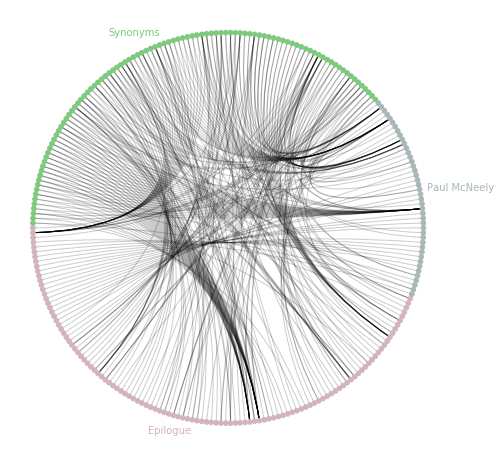

In [30]:
# They are the same
ap = nv.CircosPlot(
    new_graph_with_sim_syn, 
    node_color='vector_ind', 
    node_order='vector_ind', 
    node_grouping='doc_name', 
    group_label_position='middle',
    group_label_color=True,
    figsize=(8, 8)
)

ap.draw()
plt.show();